In [1]:
'''
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import struct
import random

# -------------------------
# Definizione del Modello
# -------------------------

class LeNet5(nn.Module):
    def __init__(self, num_classes=62):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 28x28 -> 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)       # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)             # 14x14 -> 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)       # 10x10 -> 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                   # Flatten
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -------------------------
# Implementazione Grad-CAM
# -------------------------

class GradCAM:
    def __init__(self, model, target_layer):
        """
        :param model: Il modello addestrato.
        :param target_layer: Il layer convoluzionale su cui calcolare Grad-CAM.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        # Register hooks
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        # Usa register_full_backward_hook per evitare warning
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))

    def generate_cam(self, input_image, target_class=None):
        """
        Genera la heatmap Grad-CAM per un'immagine di input.
        :param input_image: Tensor di input con shape [1, C, H, W].
        :param target_class: Classe target per cui calcolare Grad-CAM. Se None, usa la classe predetta.
        :return: Heatmap Grad-CAM.
        """
        # Forward pass
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        # Pooling dei gradienti
        gradients = self.gradients.detach().cpu().numpy()[0]  # [C, H, W]
        pooled_gradients = np.mean(gradients, axis=(1, 2))  # [C]

        # Ottieni le attivazioni
        activations = self.activations.detach().cpu().numpy()[0]  # [C, H, W]

        # Peso delle attivazioni
        for i in range(pooled_gradients.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        # Heatmap
        heatmap = np.mean(activations, axis=0)  # [H, W]
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

        return heatmap

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# -------------------------
# Definizione del Dataset in Memoria
# -------------------------

class EMNISTMemoryDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor
        self.labels = labels_tensor

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        # Dato che tutto è già in GPU, non serve trasformazione
        return self.data[idx], self.labels[idx]

# -------------------------
# Funzioni per leggere i file IDX
# -------------------------

def read_idx_images(file_path):
    """Legge immagini in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(file_path):
    """Legge etichette in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# -------------------------
# Funzione di Denormalizzazione
# -------------------------

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# -------------------------
# Mappatura delle Classi
# -------------------------

def get_emnist_class_mapping():
    """
    Mappatura delle classi EMNIST ai caratteri corrispondenti.
    EMNIST ByClass ha 62 classi: 0-9, 10-35 A-Z, 36-61 a-z
    """
    characters = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    return {i: char for i, char in enumerate(characters)}

# -------------------------
# Funzione Principale
# -------------------------

def main():
    # Impostazione dei parametri fissi
    learning_rate = 0.01
    optimizer_type = "SGD"
    grid_size = 0
    spline_order = 0
    norm_type = "None"  # Assumendo che norm_type sia "None"
    num_of_classes = 62
    batch_size = 1  # Impostiamo batch_size a 1 per il DataLoader

    # Imposta il seme per la riproducibilità
    seed = 12
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')

    # Normalizzazione
    mean, std = 0.1307, 0.3081

    # Percorso dei file decompressi
    data_dir = '/home/magliolo/.cache/emnist/gzip/'

    # Percorso del checkpoint
    base_dir = os.path.join('results', f"results_{norm_type}_{optimizer_type}_lr{learning_rate}_{grid_size}_{spline_order}", 'Standard_LeNet5')
    model_dir = os.path.join(base_dir, "model")

    # Controlla se model_dir esiste
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Directory del modello non trovata: {model_dir}")

    # Definisci il modello
    model = LeNet5(num_classes=num_of_classes).to(device)

    # Carica l'ultimo checkpoint
    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(model_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint caricato: {checkpoint_path}, Epoch: {checkpoint['epoch']}")
    model.eval()

    # Implementazione Grad-CAM
    grad_cam = GradCAM(model, target_layer=model.conv2)

    # Leggi i dati di test
    test_images_path = os.path.join(data_dir, 'emnist-byclass-test-images-idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 'emnist-byclass-test-labels-idx1-ubyte')

    print("Leggendo i dati di test...")
    images_test = read_idx_images(test_images_path)
    labels_test = read_idx_labels(test_labels_path)

    # Converti in Tensori e normalizza
    test_images_tensor = torch.from_numpy(images_test.copy()).unsqueeze(1).float()
    test_labels_tensor = torch.from_numpy(labels_test.copy()).long()

    # Normalizzazione
    test_images_tensor = (test_images_tensor - mean) / std

    # Sposta su GPU
    test_images_tensor = test_images_tensor.to(device)
    test_labels_tensor = test_labels_tensor.to(device)

    # Crea il dataset in memoria
    test_dataset = EMNISTMemoryDataset(test_images_tensor, test_labels_tensor)

    # Crea il DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Test size: {len(test_loader.dataset)}")
    print(f"Numero di classi uniche nel dataset di test: {len(set(labels_test))}")
    print(f"Etichette uniche nel dataset di test: {sorted(set(labels_test))}")

    # Mappatura delle classi
    class_mapping = get_emnist_class_mapping()

    # Seleziona un esempio dal test set (ad esempio, il primo)
    sample_data, sample_target = next(iter(test_loader))
    sample_data = sample_data.to(device)
    sample_target = sample_target.item()  # Converti in int per mappatura

    # Genera la heatmap Grad-CAM
    heatmap = grad_cam.generate_cam(sample_data, target_class=None)  # Usa la classe predetta

    # Ottieni la classe predetta
    with torch.no_grad():
        output = model(sample_data)
        pred_class = output.argmax(dim=1).item()

    # Denormalizza l'immagine originale per visualizzazione
    original_image = denormalize(sample_data.cpu().clone(), [mean], [std]).squeeze().numpy()

    # Normalizza la heatmap tra 0 e 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    
    # Converti la heatmap in formato colore
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Ridimensiona la heatmap per adattarla all'immagine originale
    heatmap_colored = cv2.resize(heatmap_colored, (original_image_rgb.shape[1], original_image_rgb.shape[0]))
    
    # Sovrapponi la heatmap all'immagine originale
    superimposed_img = heatmap_colored * 0.4 + original_image_rgb * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    # Plotta l'immagine con la heatmap sovrapposta e la legenda
    plt.figure(figsize=(8, 8))
    im = plt.imshow(superimposed_img)
    # Sincronizza la barra della legenda con il range della heatmap
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Importanza (Grad-CAM)")
    plt.clim(0, 255)  # Sincronizza i limiti della barra della legenda con i valori della heatmap
    plt.title(f"Predicted Class: {class_mapping[pred_class]}")
    plt.axis('off')
    plt.savefig(os.path.join(base_dir, 'gradcam_example_with_fixed_legend.png'))
    plt.show()

    # Pulisci i hook dopo aver finito
    grad_cam.remove_hooks()

if __name__ == "__main__":
    main()'''


'\nimport os\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport cv2\nfrom torch.utils.data import Dataset, DataLoader\nimport struct\nimport random\n\n# -------------------------\n# Definizione del Modello\n# -------------------------\n\nclass LeNet5(nn.Module):\n    def __init__(self, num_classes=62):\n        super(LeNet5, self).__init__()\n        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 28x28 -> 28x28\n        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)       # 28x28 -> 14x14\n        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)             # 14x14 -> 10x10\n        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)       # 10x10 -> 5x5\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)                   # Flatten\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, num_classes)\n\n    def forward(self, x):\n        x = F.relu(self.conv1(x))\n        x = self.pool

In [2]:
'''
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import struct
import random
import matplotlib.cm as cm
# -------------------------
# Definizione del Modello
# -------------------------

class LeNet5(nn.Module):
    def __init__(self, num_classes=62):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 28x28 -> 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)       # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)             # 14x14 -> 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)       # 10x10 -> 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                   # Flatten
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -------------------------
# Implementazione Grad-CAM
# -------------------------

class GradCAM:
    def __init__(self, model, target_layer):
        """
        :param model: Il modello addestrato.
        :param target_layer: Il layer convoluzionale su cui calcolare Grad-CAM.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        # Register hooks
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        # Usa register_full_backward_hook per evitare warning
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))

    def generate_cam(self, input_image, target_class=None):
        """
        Genera la heatmap Grad-CAM per un'immagine di input.
        :param input_image: Tensor di input con shape [1, C, H, W].
        :param target_class: Classe target per cui calcolare Grad-CAM. Se None, usa la classe predetta.
        :return: Heatmap Grad-CAM.
        """
        # Forward pass
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        # Pooling dei gradienti
        gradients = self.gradients.detach().cpu().numpy()[0]  # [C, H, W]
        pooled_gradients = np.mean(gradients, axis=(1, 2))  # [C]

        # Ottieni le attivazioni
        activations = self.activations.detach().cpu().numpy()[0]  # [C, H, W]

        # Peso delle attivazioni
        for i in range(pooled_gradients.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        # Heatmap
        heatmap = np.mean(activations, axis=0)  # [H, W]
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

        return heatmap

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# -------------------------
# Definizione del Dataset in Memoria
# -------------------------

class EMNISTMemoryDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor
        self.labels = labels_tensor

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        # Dato che tutto è già in GPU, non serve trasformazione
        return self.data[idx], self.labels[idx]

# -------------------------
# Funzioni per leggere i file IDX
# -------------------------

def read_idx_images(file_path):
    """Legge immagini in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(file_path):
    """Legge etichette in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# -------------------------
# Funzione di Denormalizzazione
# -------------------------

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# -------------------------
# Mappatura delle Classi
# -------------------------

def get_emnist_class_mapping():
    """
    Mappatura delle classi EMNIST ai caratteri corrispondenti.
    EMNIST ByClass ha 62 classi: 0-9, 10-35 A-Z, 36-61 a-z
    """
    characters = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    return {i: char for i, char in enumerate(characters)}

# -------------------------
# Funzione Principale
# -------------------------

def main():
    # Impostazione dei parametri fissi
    learning_rate = 0.01
    optimizer_type = "SGD"
    grid_size = 0
    spline_order = 0
    norm_type = "None"  # Assumendo che norm_type sia "None"
    num_of_classes = 62
    batch_size = 1  # Impostiamo batch_size a 1 per il DataLoader

    # Imposta il seme per la riproducibilità
    seed = 12
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')

    # Normalizzazione
    mean, std = 0.1307, 0.3081

    # Percorso dei file decompressi
    data_dir = '/home/magliolo/.cache/emnist/gzip/'

    # Percorso del checkpoint
    base_dir = os.path.join('results', f"results_{norm_type}_{optimizer_type}_lr{learning_rate}_{grid_size}_{spline_order}", 'Standard_LeNet5')
    model_dir = os.path.join(base_dir, "model")

    # Controlla se model_dir esiste
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Directory del modello non trovata: {model_dir}")

    # Definisci il modello
    model = LeNet5(num_classes=num_of_classes).to(device)

    # Carica l'ultimo checkpoint
    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(model_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint caricato: {checkpoint_path}, Epoch: {checkpoint['epoch']}")
    model.eval()

    # Implementazione Grad-CAM
    grad_cam = GradCAM(model, target_layer=model.conv2)

    # Leggi i dati di test
    test_images_path = os.path.join(data_dir, 'emnist-byclass-test-images-idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 'emnist-byclass-test-labels-idx1-ubyte')

    print("Leggendo i dati di test...")
    images_test = read_idx_images(test_images_path)
    labels_test = read_idx_labels(test_labels_path)

    # Converti in Tensori e normalizza
    test_images_tensor = torch.from_numpy(images_test.copy()).unsqueeze(1).float()
    test_labels_tensor = torch.from_numpy(labels_test.copy()).long()

    # Normalizzazione
    test_images_tensor = (test_images_tensor - mean) / std

    # Sposta su GPU
    test_images_tensor = test_images_tensor.to(device)
    test_labels_tensor = test_labels_tensor.to(device)

    # Crea il dataset in memoria
    test_dataset = EMNISTMemoryDataset(test_images_tensor, test_labels_tensor)

    # Crea il DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Test size: {len(test_loader.dataset)}")
    print(f"Numero di classi uniche nel dataset di test: {len(set(labels_test))}")
    print(f"Etichette uniche nel dataset di test: {sorted(set(labels_test))}")

    # Mappatura delle classi
    class_mapping = get_emnist_class_mapping()

    # Seleziona un esempio dal test set (ad esempio, il primo)
    sample_data, sample_target = next(iter(test_loader))
    sample_data = sample_data.to(device)
    sample_target = sample_target.item()  # Converti in int per mappatura

    # Genera la heatmap Grad-CAM
    heatmap = grad_cam.generate_cam(sample_data, target_class=None)  # Usa la classe predetta

    # Ottieni la classe predetta
    with torch.no_grad():
        output = model(sample_data)
        pred_class = output.argmax(dim=1).item()

    # Crea la directory per salvare le immagini se non esiste
    os.makedirs(base_dir, exist_ok=True)
    
    # Denormalizza l'immagine originale per visualizzazione
    original_image = denormalize(sample_data.cpu().clone(), [mean], [std]).squeeze().numpy()

    # Converti l'immagine originale in RGB
    original_image_rgb = np.stack([original_image]*3, axis=2)  # [H, W, 3]
    original_image_rgb = np.uint8(255 * original_image_rgb)
    
    # Plotta l'immagine originale con la classe vera
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Immagine Originale - Classe Vera: {class_mapping[sample_target]}")
    plt.axis('off')
    plt.savefig(os.path.join(base_dir, 'original_image.png'))
    plt.show()
    
    # Normalizza la heatmap tra 0 e 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() if heatmap.max() != 0 else 1
    
    # Ottieni la colormap JET da matplotlib
    cmap = cm.get_cmap('jet')
    colored_heatmap = cmap(heatmap)[:, :, :3]  # RGBA -> RGB
    colored_heatmap = np.uint8(255 * colored_heatmap)
    
    # A questo punto colored_heatmap è una mappa di colori coerente con 'jet'
    # Mostra prima la heatmap pura con la colorbar
    plt.figure(figsize=(8, 8))
    hm_im = plt.imshow(heatmap, cmap='jet', interpolation='nearest')
    cbar = plt.colorbar(hm_im, fraction=0.046, pad=0.04, label="Importanza (Grad-CAM)")
    plt.title("Heatmap")
    plt.axis('off')
    plt.savefig(os.path.join(base_dir, 'gradcam_heatmap.png'))
    plt.show()
    
    # Ora ridimensiona la heatmap colorata per adattarla all'immagine originale
    colored_heatmap = cv2.resize(colored_heatmap, (original_image_rgb.shape[1], original_image_rgb.shape[0]))
    
    # Sovrapponi la heatmap all'immagine originale
    superimposed_img = 0.4 * colored_heatmap + 0.6 * original_image_rgb
    superimposed_img = superimposed_img.astype(np.uint8)
    
    # Plotta l'immagine sovrapposta senza la colorbar
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.title(f"Predicted Class: {class_mapping[pred_class]}")
    plt.axis('off')
    plt.savefig(os.path.join(base_dir, 'gradcam_overlay.png'))
    plt.show()




    # Pulisci i hook dopo aver finito
    grad_cam.remove_hooks()

if __name__ == "__main__":
    main()
'''

'\nimport os\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport cv2\nfrom torch.utils.data import Dataset, DataLoader\nimport struct\nimport random\nimport matplotlib.cm as cm\n# -------------------------\n# Definizione del Modello\n# -------------------------\n\nclass LeNet5(nn.Module):\n    def __init__(self, num_classes=62):\n        super(LeNet5, self).__init__()\n        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 28x28 -> 28x28\n        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)       # 28x28 -> 14x14\n        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)             # 14x14 -> 10x10\n        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)       # 10x10 -> 5x5\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)                   # Flatten\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, num_classes)\n\n    def forward(self, x):\n        x = F.relu(self.conv1(

Device: cuda
Checkpoint caricato: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/model/checkpoint_epoch_50.pth, Epoch: 50
Leggendo i dati di test...
Test size: 116323
Numero di classi uniche nel dataset di test: 62
Etichette uniche nel dataset di test: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

Generando Grad-CAM per l'indice: 9


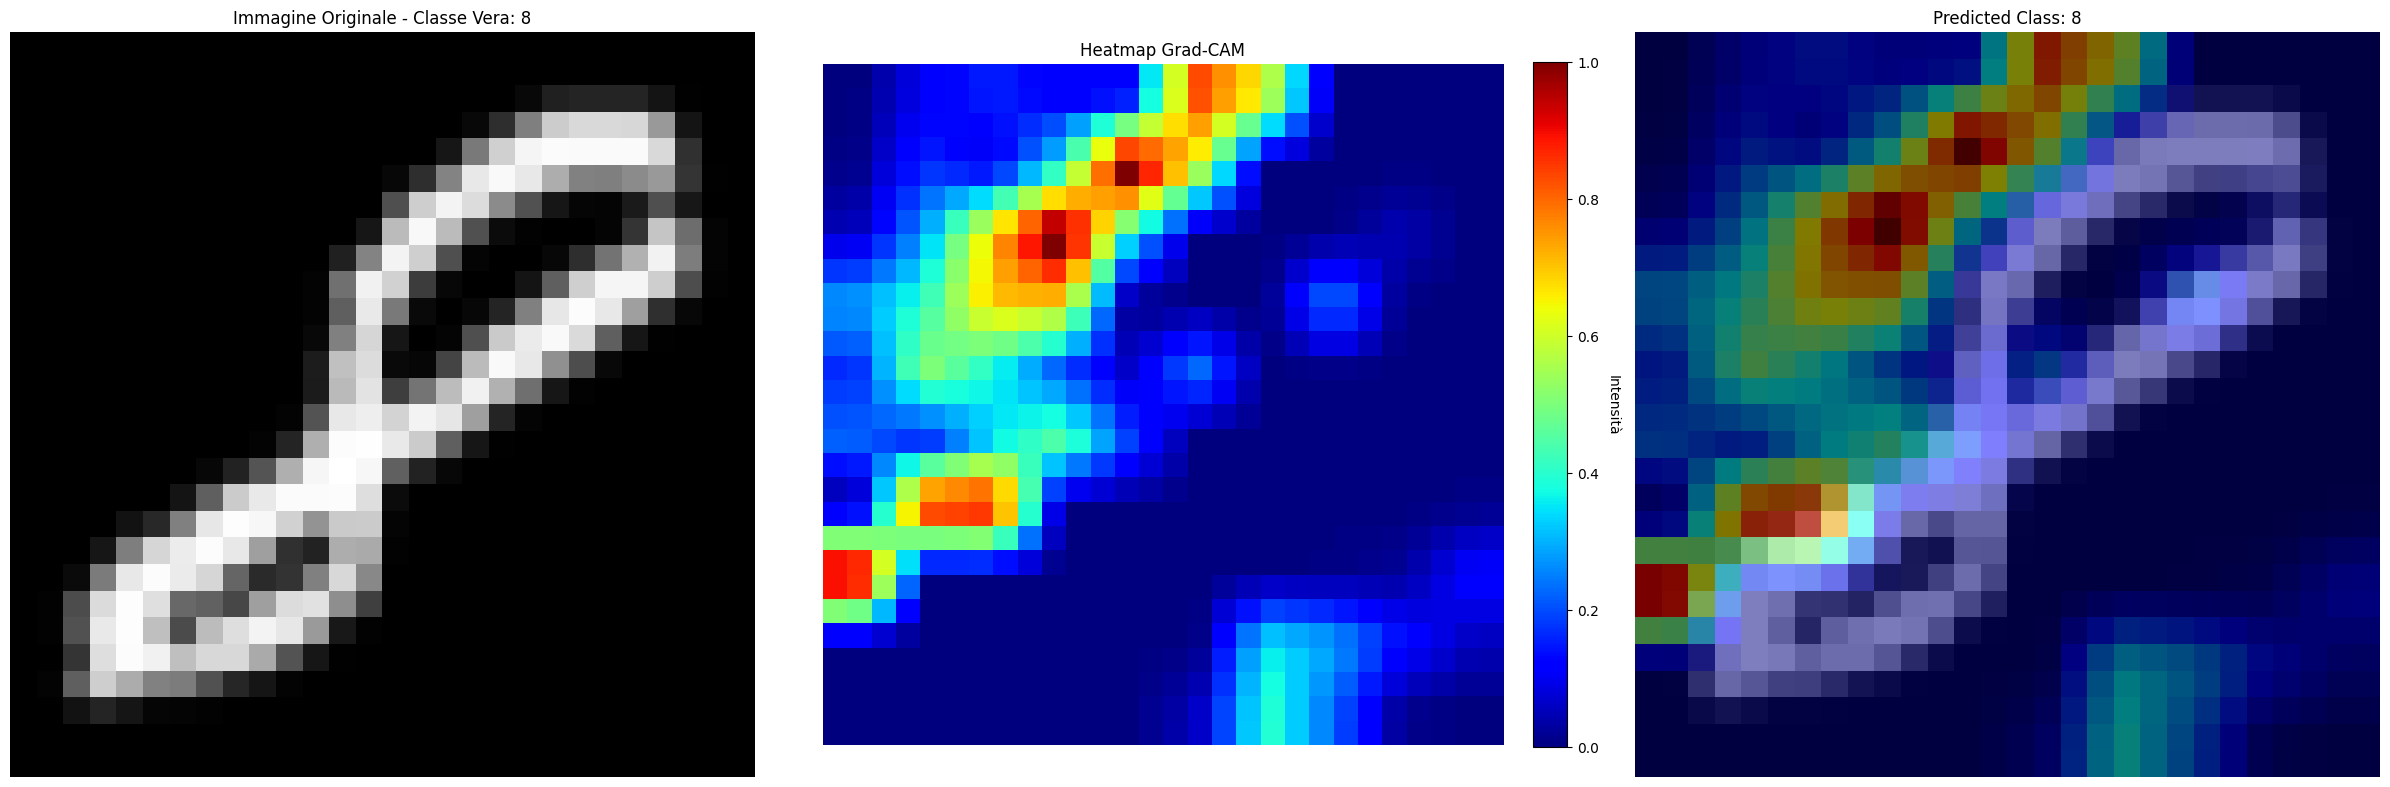

Plots salvati in: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_9.png

Generando Grad-CAM per l'indice: 15


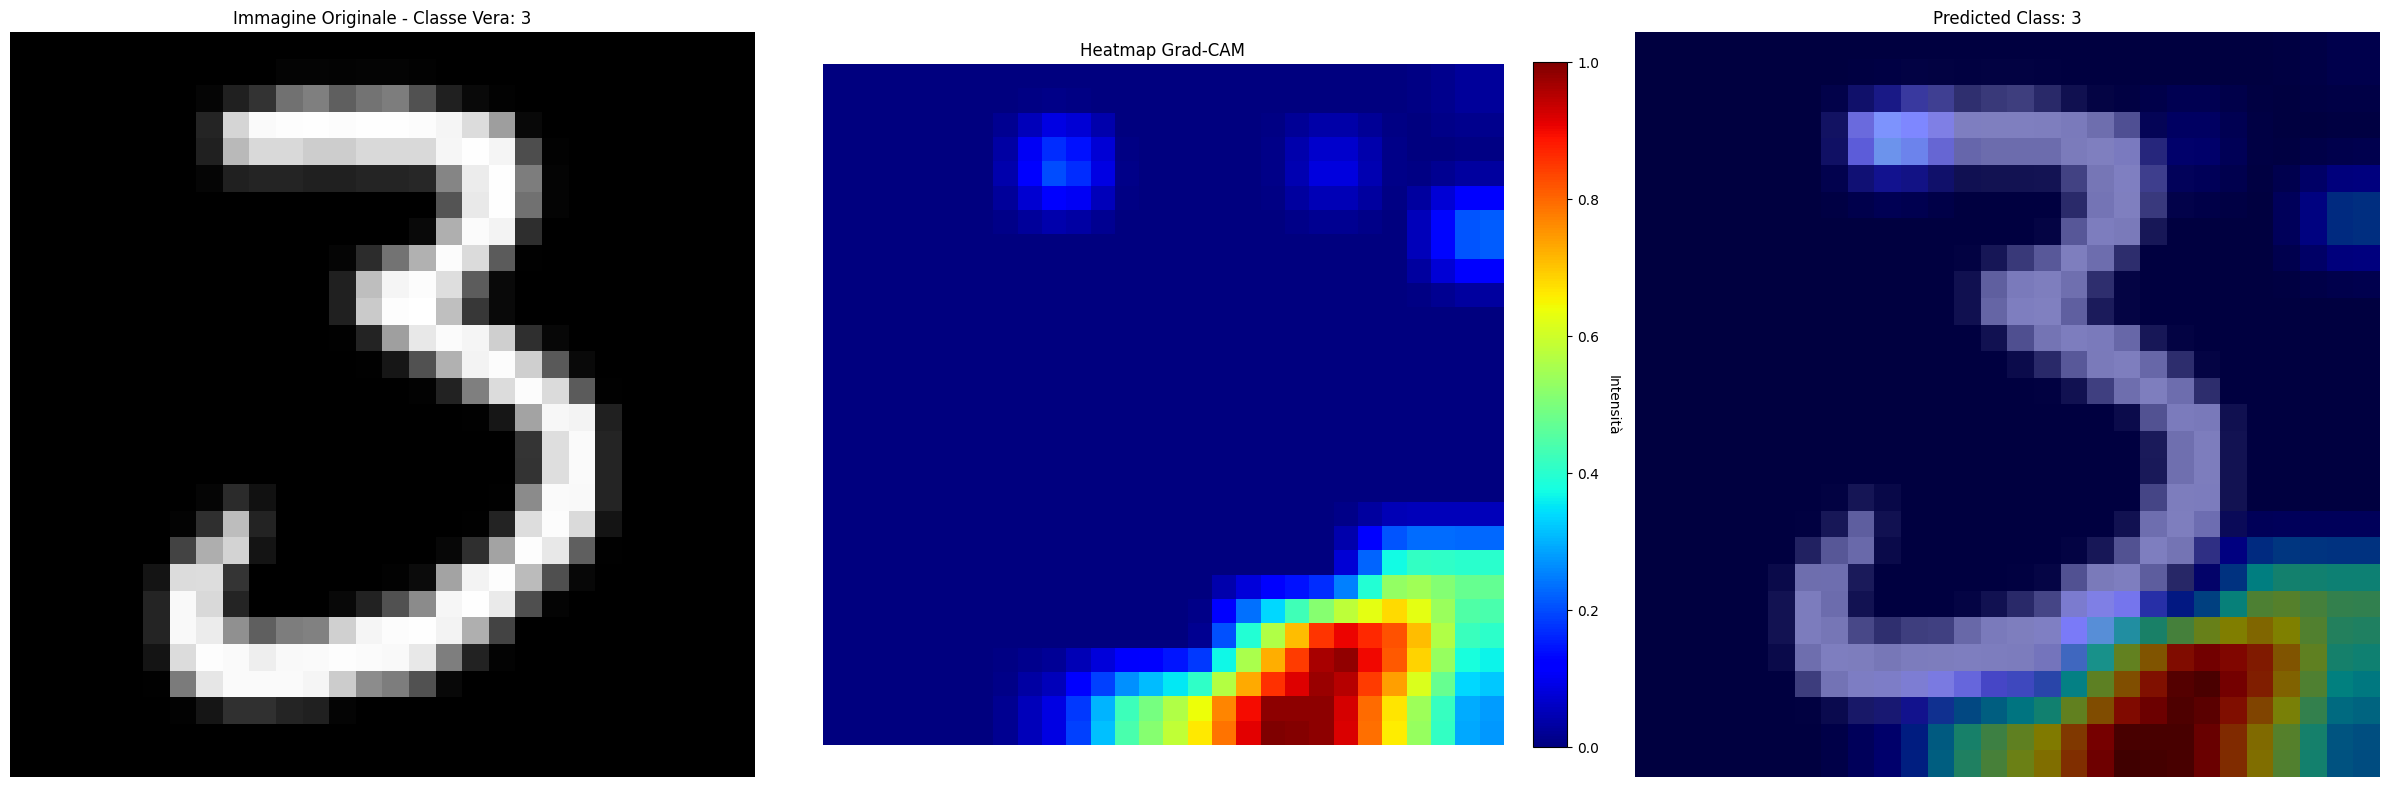

Plots salvati in: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_15.png

Generando Grad-CAM per l'indice: 23


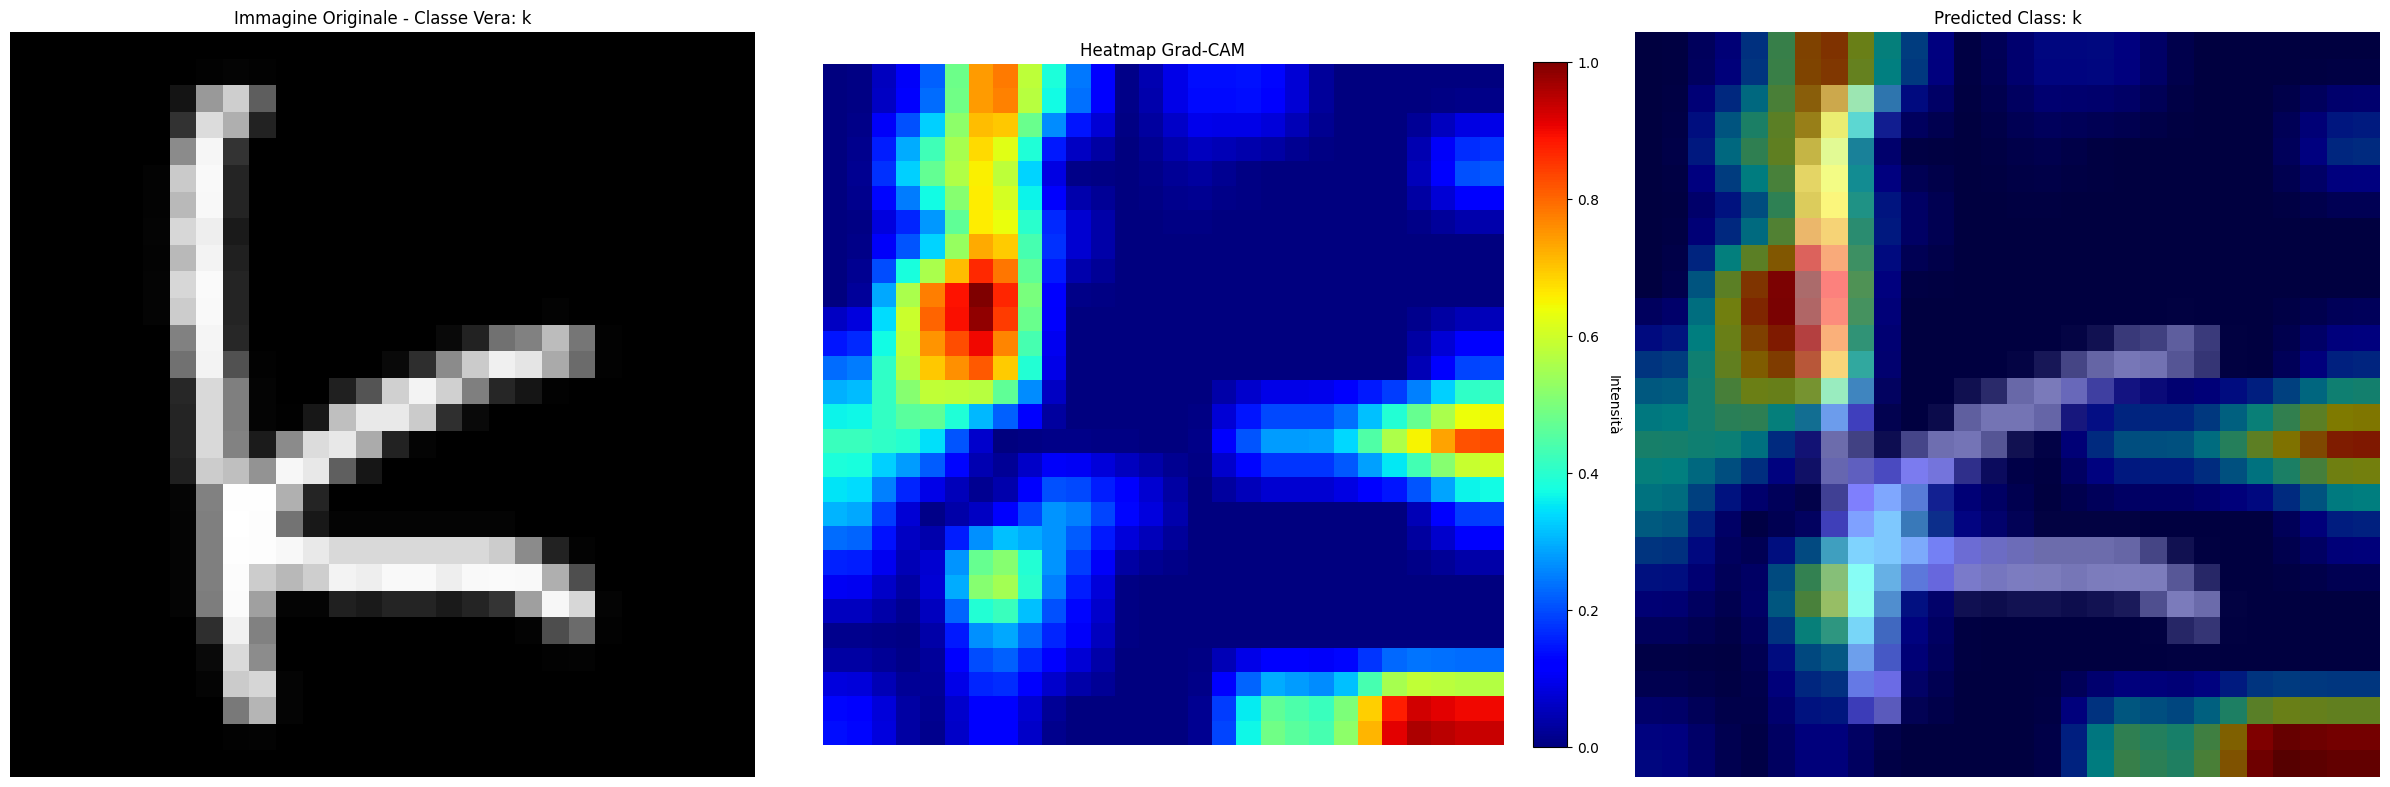

Plots salvati in: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_23.png

Generando Grad-CAM per l'indice: 24


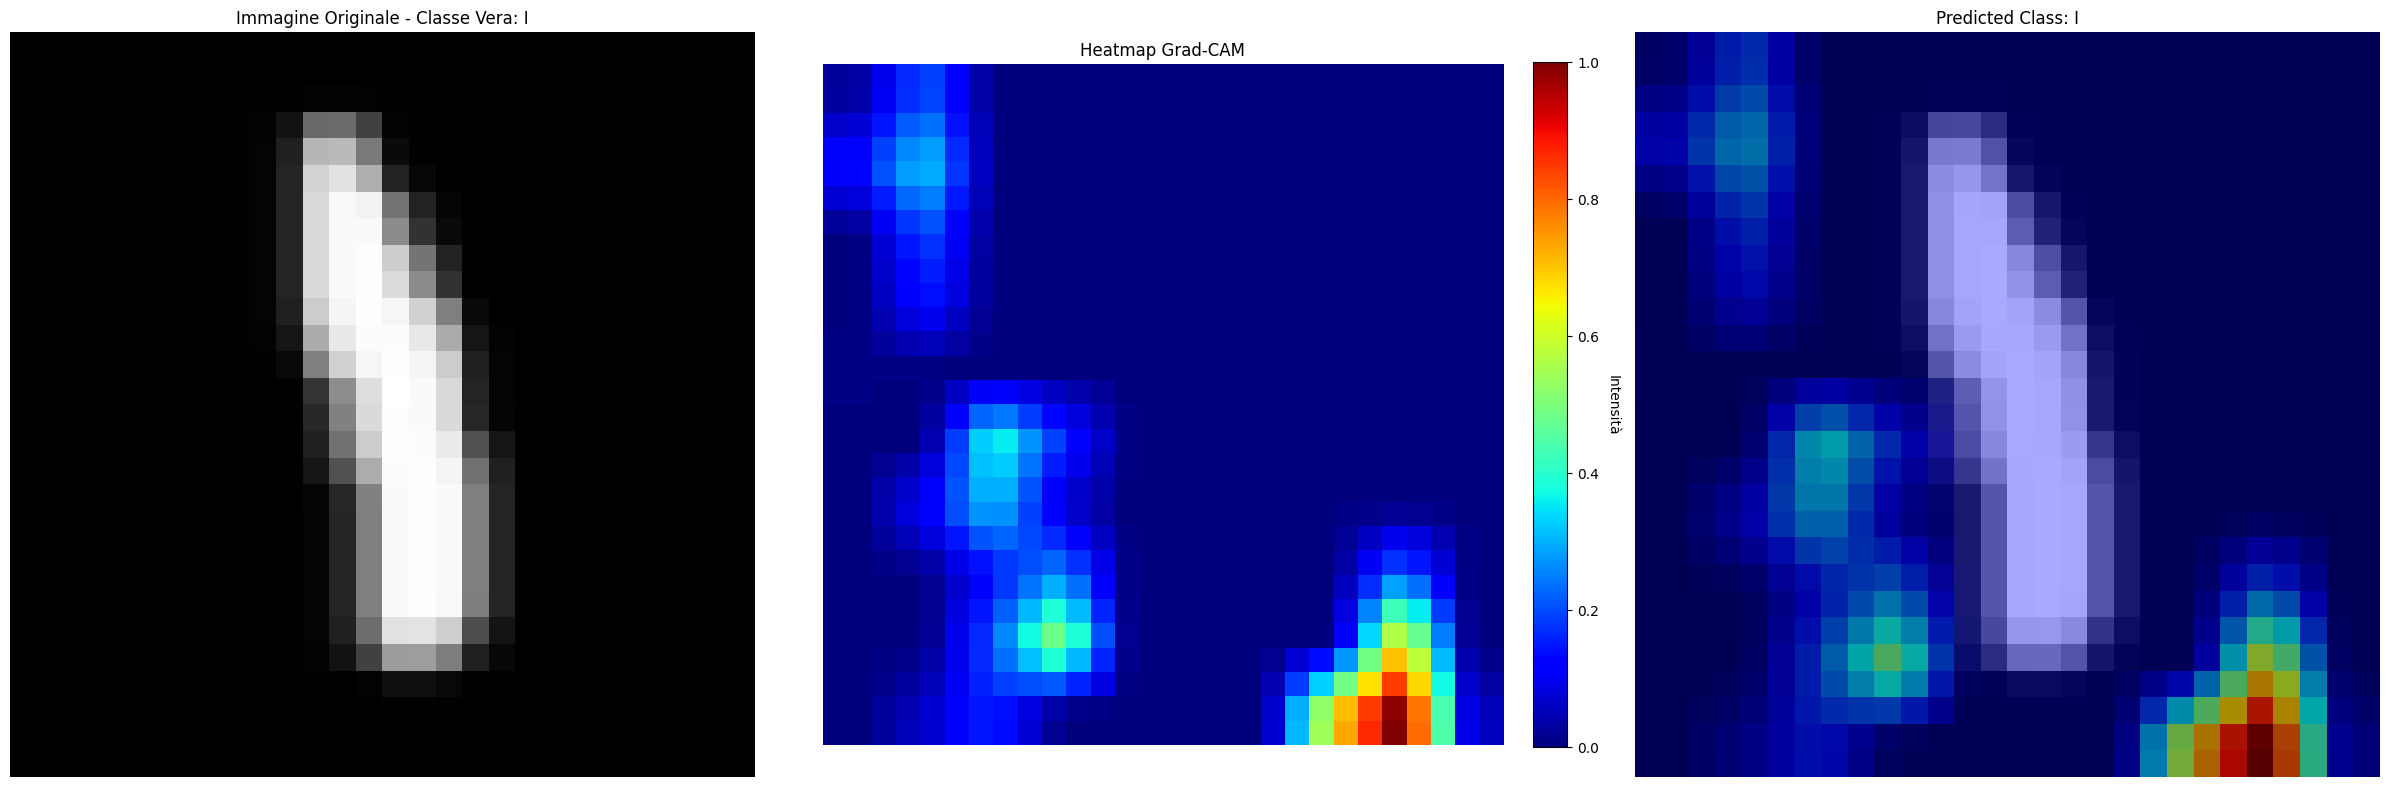

Plots salvati in: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_24.png

Generando Grad-CAM per l'indice: 25


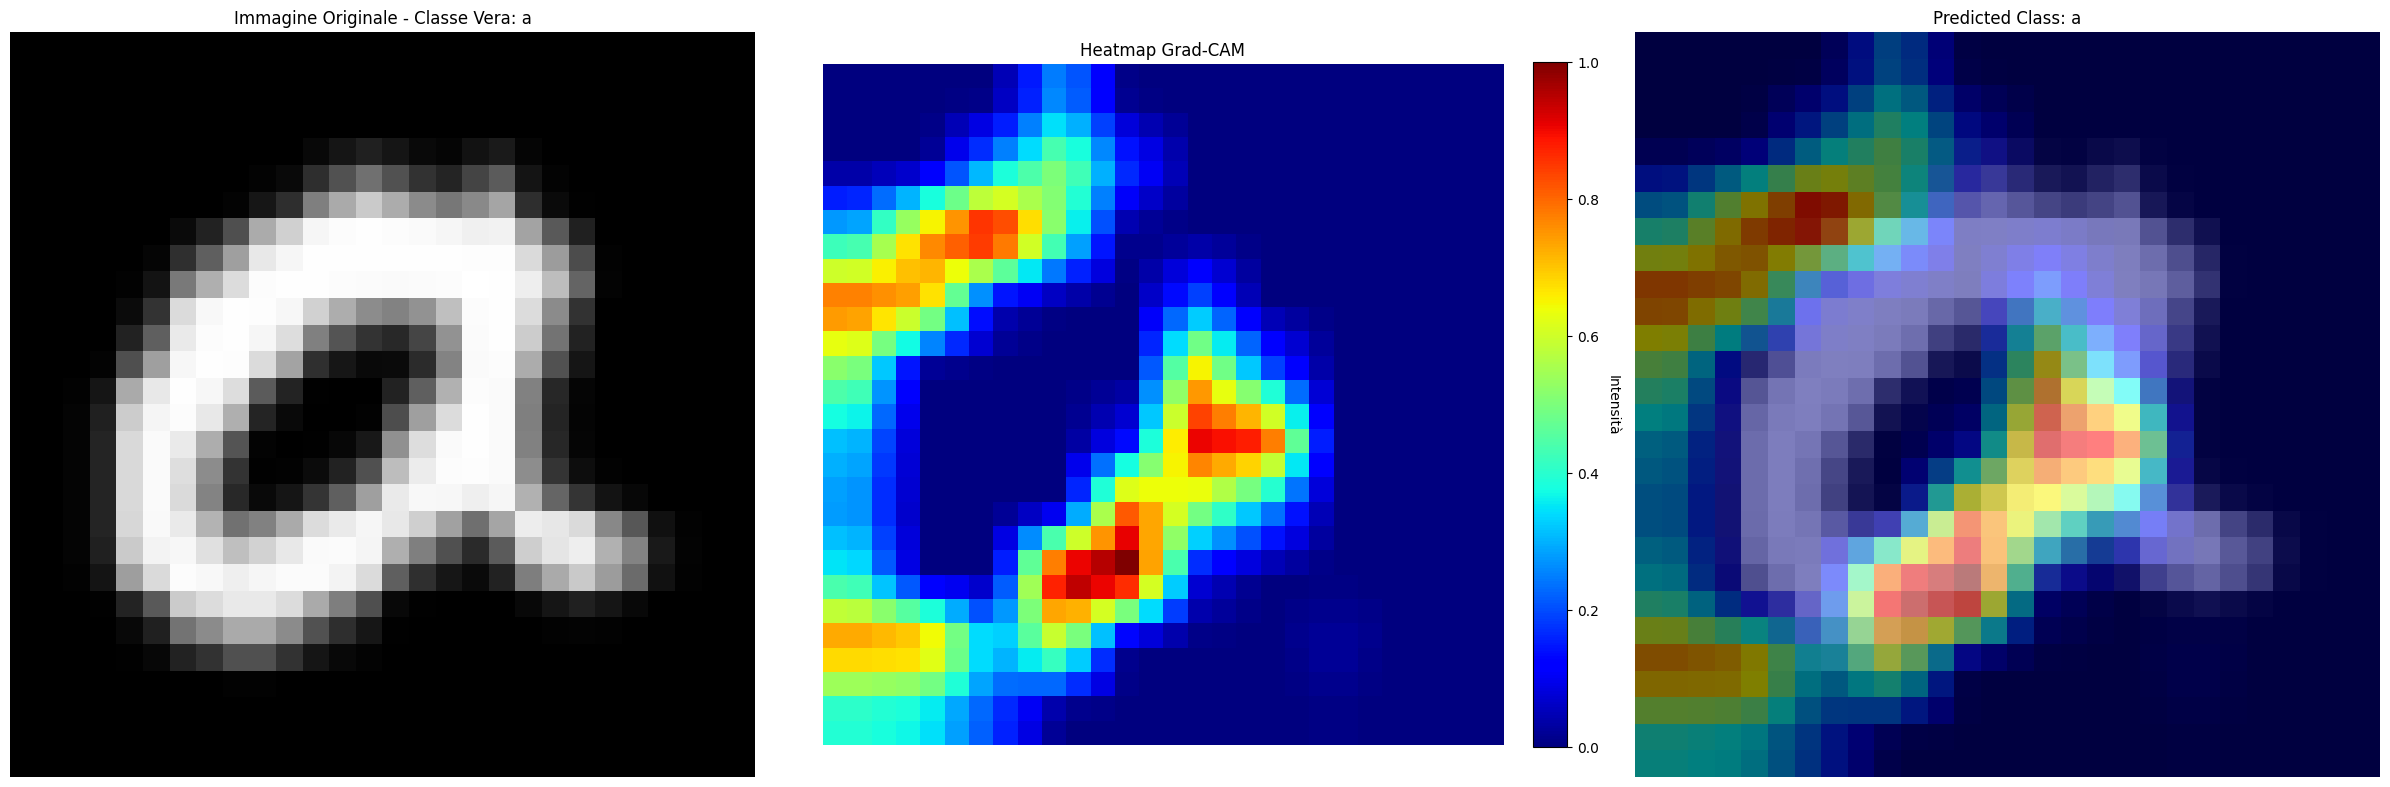

Plots salvati in: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_25.png

Generando Grad-CAM per l'indice: 26


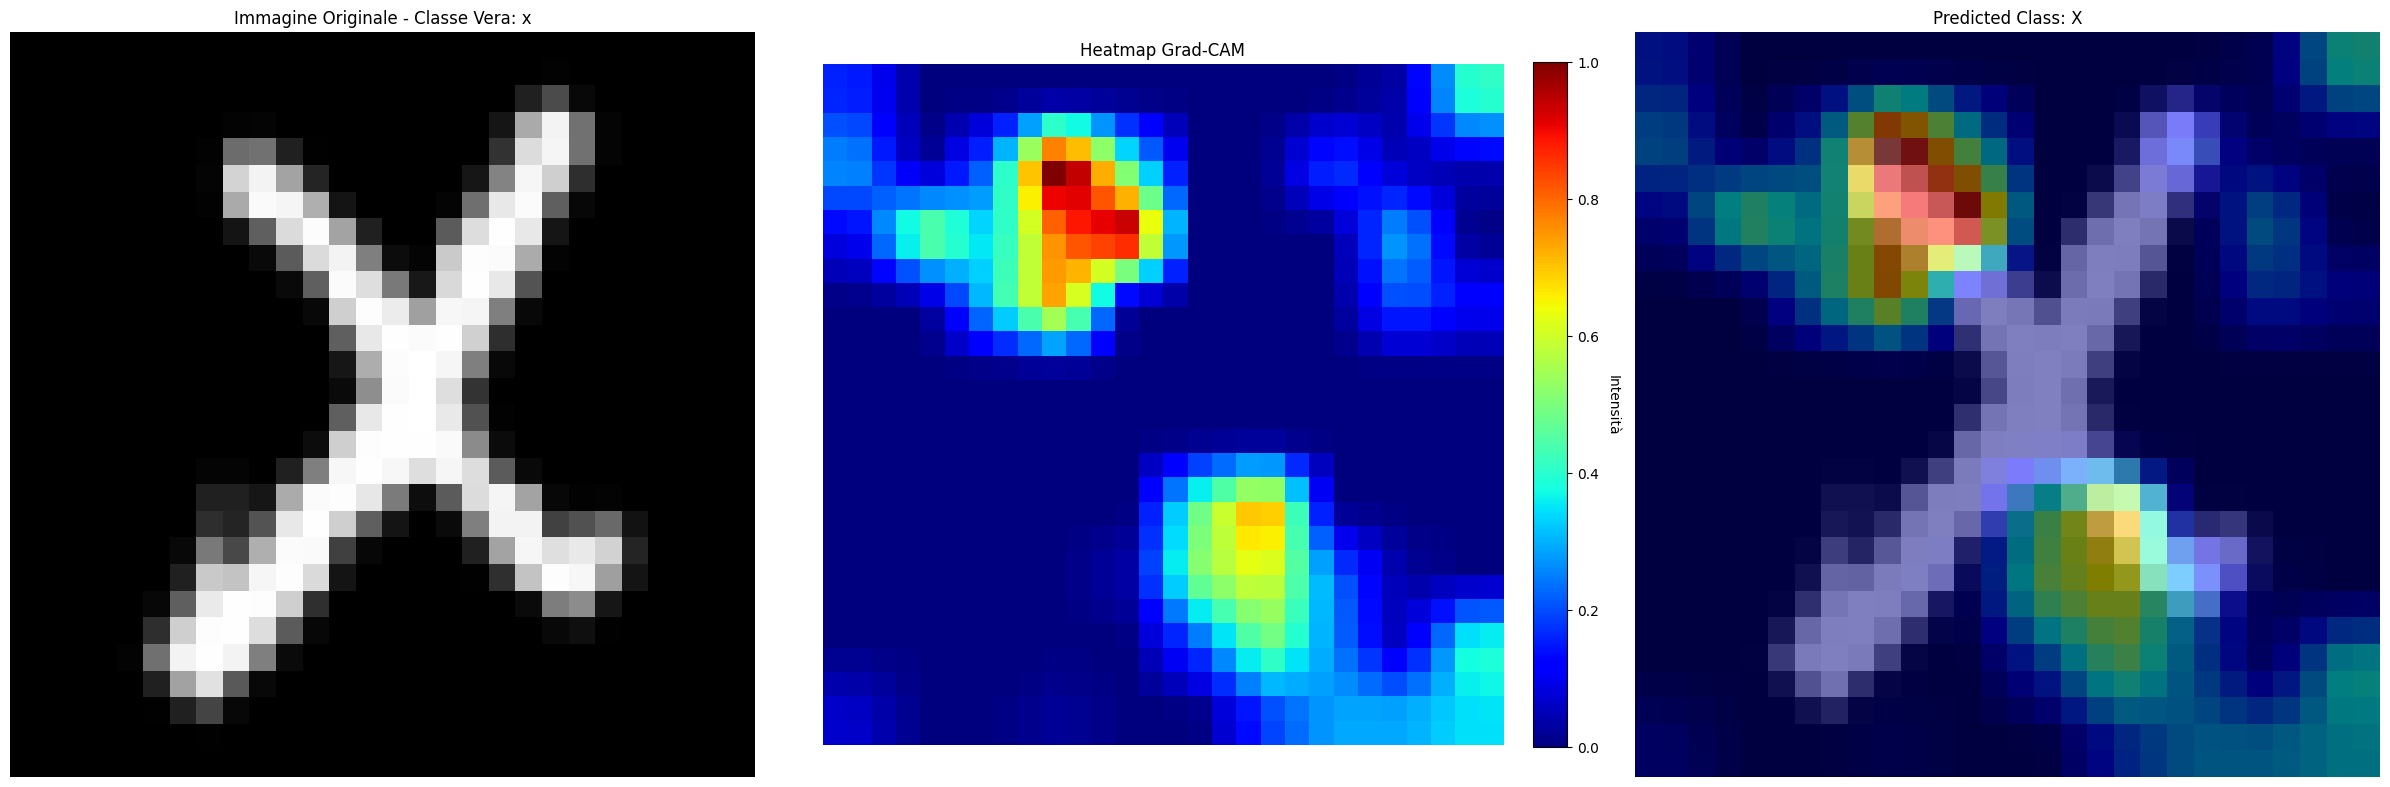

Plots salvati in: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_26.png

Generando Grad-CAM per l'indice: 27


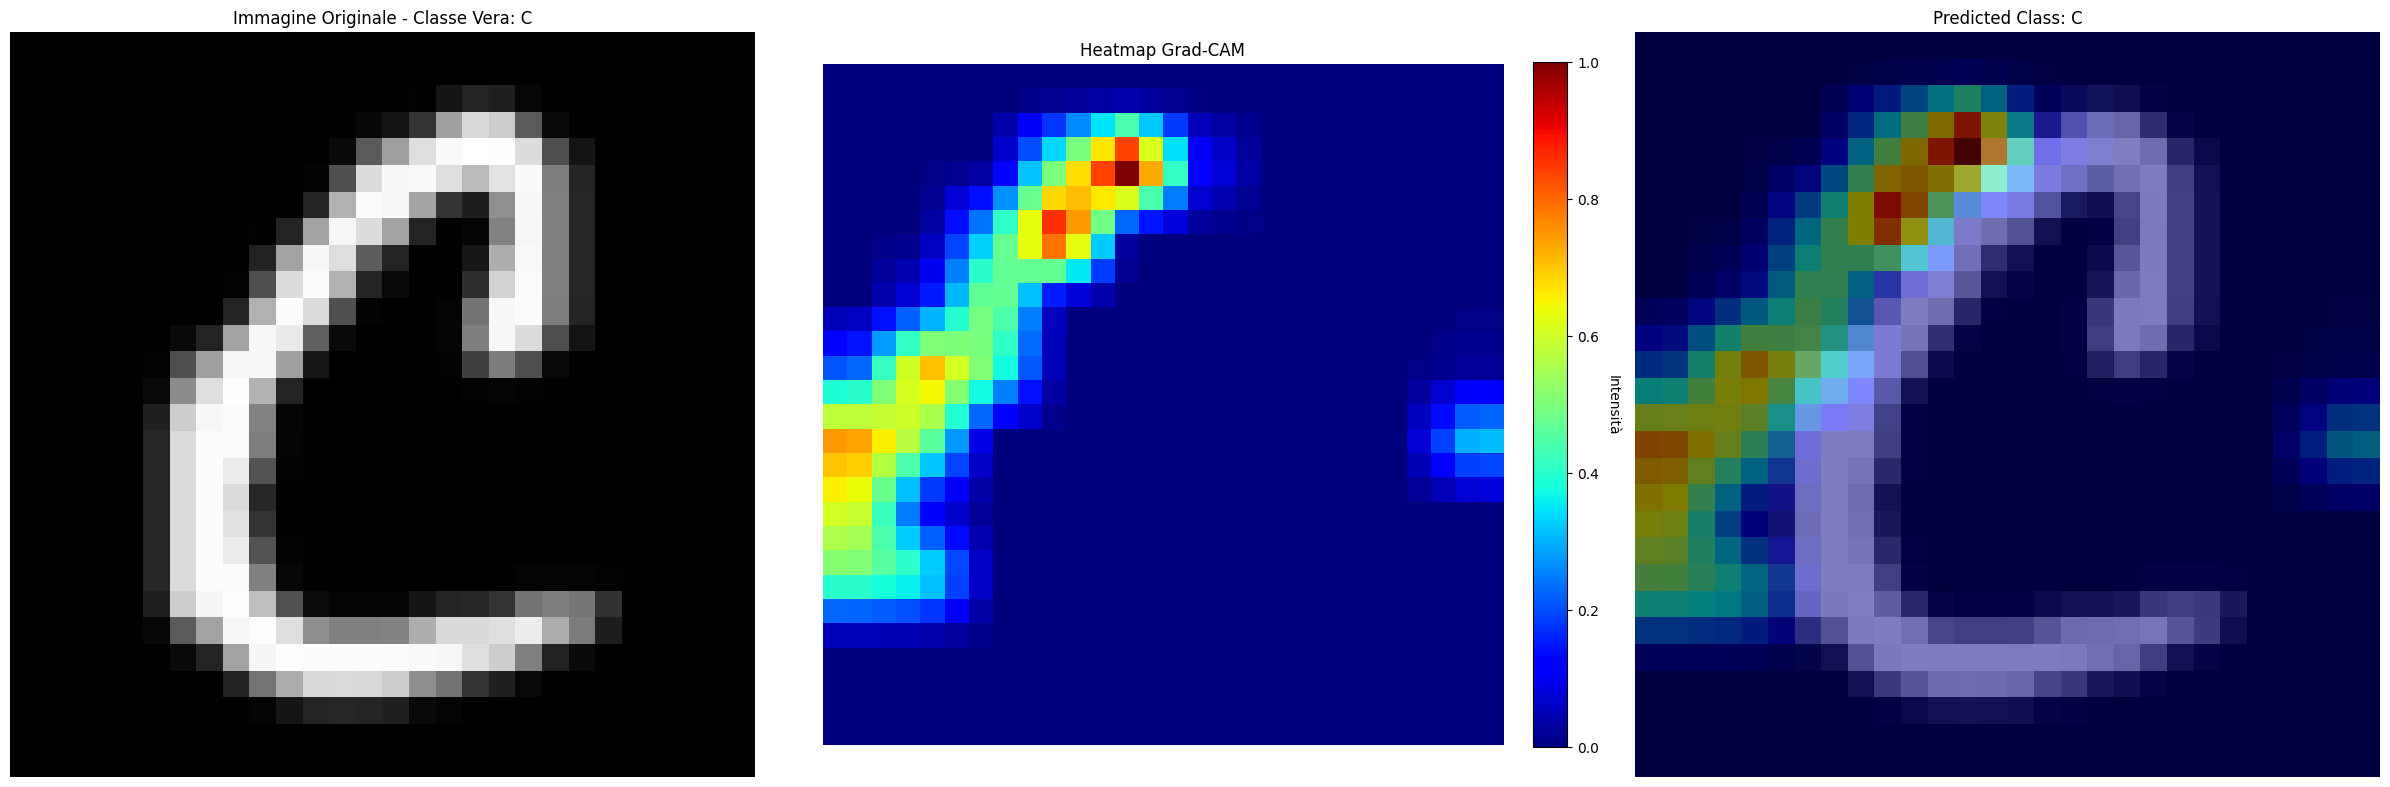

Plots salvati in: results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_27.png


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import struct
import random

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# -------------------------
# Definizione del Modello
# -------------------------

class LeNet5(nn.Module):
    def __init__(self, num_classes=62):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 28x28 -> 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)       # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)             # 14x14 -> 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)       # 10x10 -> 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                   # Flatten
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -------------------------
# Definizione del Dataset in Memoria
# -------------------------

class EMNISTMemoryDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor
        self.labels = labels_tensor

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# -------------------------
# Funzioni per leggere i file IDX
# -------------------------

def read_idx_images(file_path):
    """Legge immagini in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(file_path):
    """Legge etichette in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# -------------------------
# Funzione di Denormalizzazione
# -------------------------

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# -------------------------
# Mappatura delle Classi
# -------------------------

def get_emnist_class_mapping():
    """
    Mappatura delle classi EMNIST ai caratteri corrispondenti.
    EMNIST ByClass ha 62 classi: 0-9, 10-35 A-Z, 36-61 a-z
    """
    characters = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    return {i: char for i, char in enumerate(characters)}

# -------------------------
# Funzione per Estrarre un Campione Specifico
# -------------------------

def get_sample_by_index(dataset, index):
    """
    Estrae un campione specifico dal dataset utilizzando un indice.
    
    Args:
        dataset (Dataset): Il dataset da cui estrarre il campione.
        index (int): L'indice del campione da estrarre.
    
    Returns:
        tuple: (sample_data, sample_target)
    """
    if index < 0 or index >= len(dataset):
        raise IndexError("Indice fuori dal range del dataset.")
    sample_data, sample_target = dataset[index]
    return sample_data.unsqueeze(0), sample_target  # Aggiungi dimensione batch

# -------------------------
# Funzione per Generare e Visualizzare Grad-CAM
# -------------------------

def generate_gradcam_plots(sample_index):
    """
    Genera e visualizza le heatmap Grad-CAM per un campione specifico.
    
    Args:
        sample_index (int): L'indice del campione da analizzare.
    """
    # Verifica che l'indice sia valido
    if sample_index < 0 or sample_index >= len(test_dataset):
        raise IndexError(f"Indice {sample_index} fuori dal range del dataset.")

    # Estrai il campione specifico
    sample_data, sample_target = get_sample_by_index(test_dataset, sample_index)
    sample_data = sample_data.to(device)
    sample_target = sample_target.item()

    # Definisci il target layer
    target_layer = model.conv2

    # Inizializza GradCAM dalla libreria pytorch-grad-cam
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Genera la heatmap Grad-CAM
    grayscale_cam = cam(input_tensor=sample_data, targets=None)  # None = classe predetta
    grayscale_cam = grayscale_cam[0]  # Rimuovi dimensione batch

    # Normalizza la heatmap tra 0 e 1
    grayscale_cam_normalized = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    # Ottieni la classe predetta
    with torch.no_grad():
        output = model(sample_data)
    pred_class = output.argmax(dim=1).item()

    # Denormalizza l'immagine originale per visualizzazione
    original_image = denormalize(sample_data.cpu().clone(), [mean], [std]).squeeze().numpy()

    # Flip orizzontale e rotazione di 90 gradi anti-clockwise
    original_image = np.fliplr(original_image)  # Flip orizzontale
    original_image = np.rot90(original_image, k=1)  # Rotazione di 90 gradi anti-clockwise

    grayscale_cam_normalized = np.fliplr(grayscale_cam_normalized)  # Flip orizzontale della heatmap
    grayscale_cam_normalized = np.rot90(grayscale_cam_normalized, k=1)  # Rotazione di 90 gradi anti-clockwise della heatmap

    # Converti l'immagine originale in RGB e normalizzala tra 0 e 1
    original_image_rgb = np.stack([original_image]*3, axis=2)  # [H, W, 3]
    original_image_rgb = original_image_rgb / 255.0  # Assicurati che l'immagine sia tra 0 e 1

    # Usa show_cam_on_image per sovrapporre la cam
    visualization = show_cam_on_image(original_image_rgb, grayscale_cam_normalized, use_rgb=True)

    # Crea una figura con 3 subplot
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))

    # Plot 1: Immagine Originale
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title(f"Immagine Originale - Classe Vera: {class_mapping[sample_target]}")
    axs[0].axis('off')

    # Plot 2: Heatmap Grad-CAM Isolata
    im = axs[1].imshow(grayscale_cam_normalized, cmap='jet')
    axs[1].set_title("Heatmap Grad-CAM")
    axs[1].axis('off')
    # Aggiungi una barra laterale (colorbar)
    cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Intensità', rotation=270, labelpad=15)

    # Plot 3: Immagine con Heatmap Sovrapposta
    axs[2].imshow(visualization)
    axs[2].set_title(f"Predicted Class: {class_mapping[pred_class]}")
    axs[2].axis('off')

    # Salva e mostra la figura completa
    plt.tight_layout()
    save_path = os.path.join(base_dir, f'gradcam_plots_sample_{sample_index}.png')
    plt.savefig(save_path)
    plt.show()

    print(f"Plots salvati in: {save_path}")

    # Pulisci i hook dopo aver finito
    cam = None  # Libera risorse (GradCAM chiama automaticamente remove hooks nel suo metodo __del__)

# -------------------------
# Funzione Principale
# -------------------------

def main():
    global model, test_dataset, class_mapping, mean, std, base_dir, device

    # Impostazione dei parametri fissi
    learning_rate = 0.01
    optimizer_type = "SGD"
    grid_size = 0
    spline_order = 0
    norm_type = "None"
    num_of_classes = 62
    batch_size = 1

    # Seme per riproducibilità
    seed = 12
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')

    mean, std = 0.1307, 0.3081

    data_dir = '/home/magliolo/.cache/emnist/gzip/'

    base_dir = os.path.join(
        'results',
        f"results_{norm_type}_{optimizer_type}_lr{learning_rate}_{grid_size}_{spline_order}",
        'Standard_LeNet5'
    )
    model_dir = os.path.join(base_dir, "model")

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Directory del modello non trovata: {model_dir}")

    model = LeNet5(num_classes=num_of_classes).to(device)

    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    if not checkpoints:
        raise FileNotFoundError(f"Nessun checkpoint trovato nella directory: {model_dir}")
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(model_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint caricato: {checkpoint_path}, Epoch: {checkpoint['epoch']}")
    model.eval()

    # Leggi i dati di test
    test_images_path = os.path.join(data_dir, 'emnist-byclass-test-images-idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 'emnist-byclass-test-labels-idx1-ubyte')

    print("Leggendo i dati di test...")
    images_test = read_idx_images(test_images_path)
    labels_test = read_idx_labels(test_labels_path)

    # Converti in Tensori e normalizza
    test_images_tensor = torch.from_numpy(images_test.copy()).unsqueeze(1).float()
    test_labels_tensor = torch.from_numpy(labels_test.copy()).long()

    # Normalizzazione
    test_images_tensor = (test_images_tensor - mean) / std

    # Sposta su GPU
    test_images_tensor = test_images_tensor.to(device)
    test_labels_tensor = test_labels_tensor.to(device)

    # Crea il dataset in memoria
    test_dataset = EMNISTMemoryDataset(test_images_tensor, test_labels_tensor)

    # Crea il DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Test size: {len(test_loader.dataset)}")
    print(f"Numero di classi uniche nel dataset di test: {len(set(labels_test))}")
    print(f"Etichette uniche nel dataset di test: {sorted(set(labels_test))}")

    # Mappatura delle classi
    class_mapping = get_emnist_class_mapping()

    # Ora puoi chiamare la funzione `generate_gradcam_plots` con l'indice desiderato
    # Esempio:
    sample_indices = [9, 15, 23, 24, 25, 26, 27]  # Puoi aggiungere altri indici qui

    for sample_index in sample_indices:
        print(f"\nGenerando Grad-CAM per l'indice: {sample_index}")
        try:
            generate_gradcam_plots(sample_index)
        except Exception as e:
            print(f"Errore nella generazione della heatmap per l'indice {sample_index}: {e}")

if __name__ == "__main__":
    main()


Device: cuda
Checkpoint caricato: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/model/checkpoint_epoch_50.pth, Epoch: 50
Leggendo i dati di test...
Test size: 116323
Numero di classi uniche nel dataset di test: 62
Etichette uniche nel dataset di test: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

Generando Grad-CAM per l'indice: 9


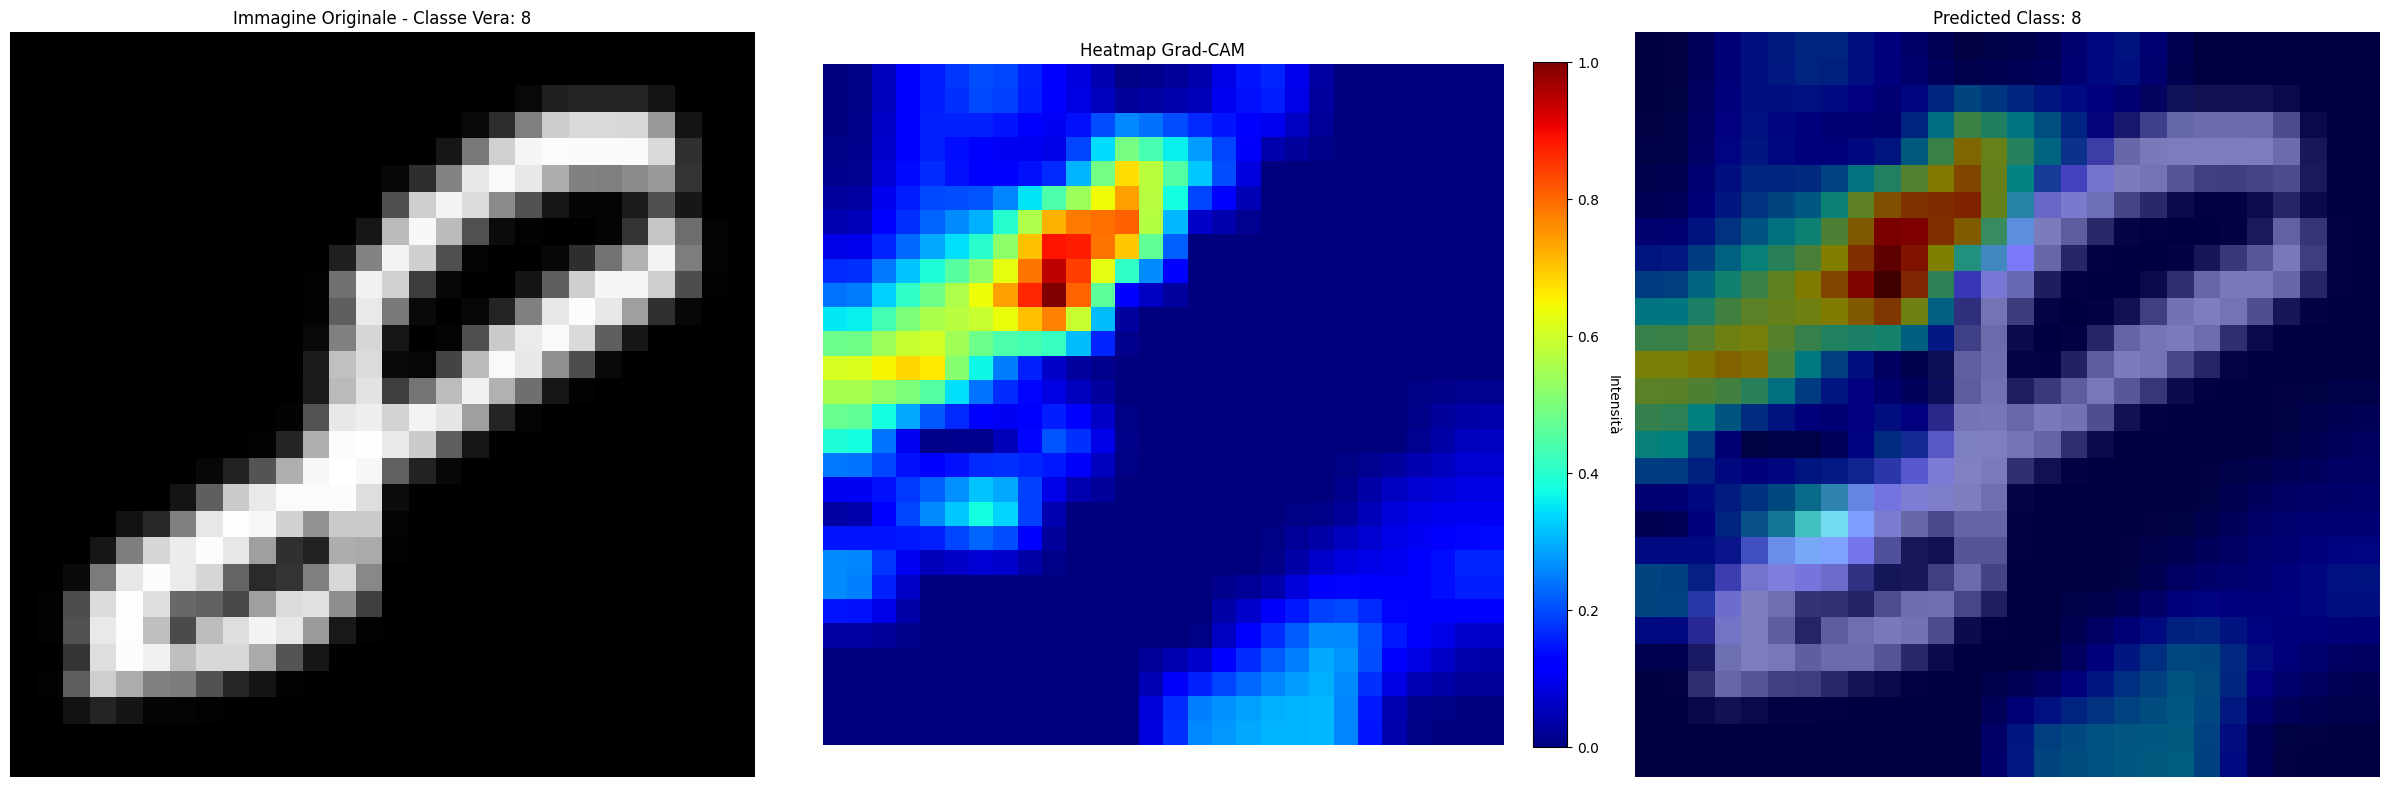

Plots salvati in: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_9.png

Generando Grad-CAM per l'indice: 15


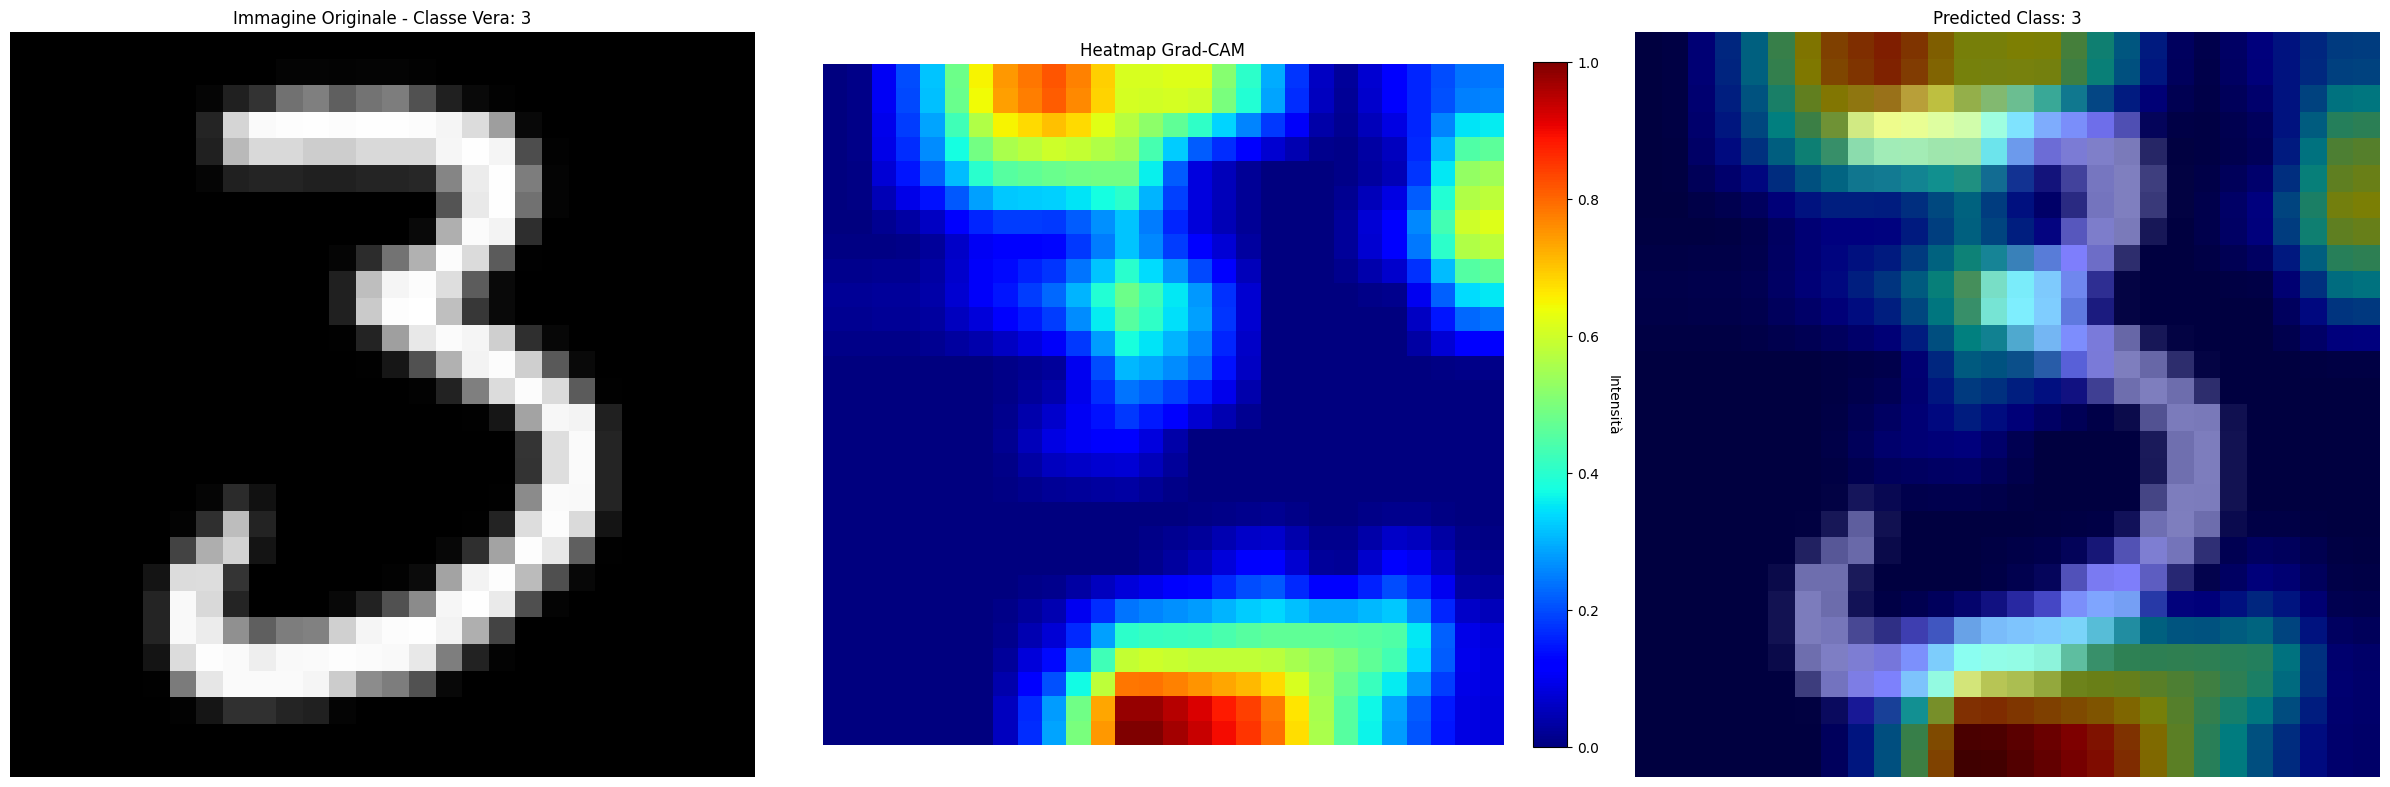

Plots salvati in: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_15.png

Generando Grad-CAM per l'indice: 23


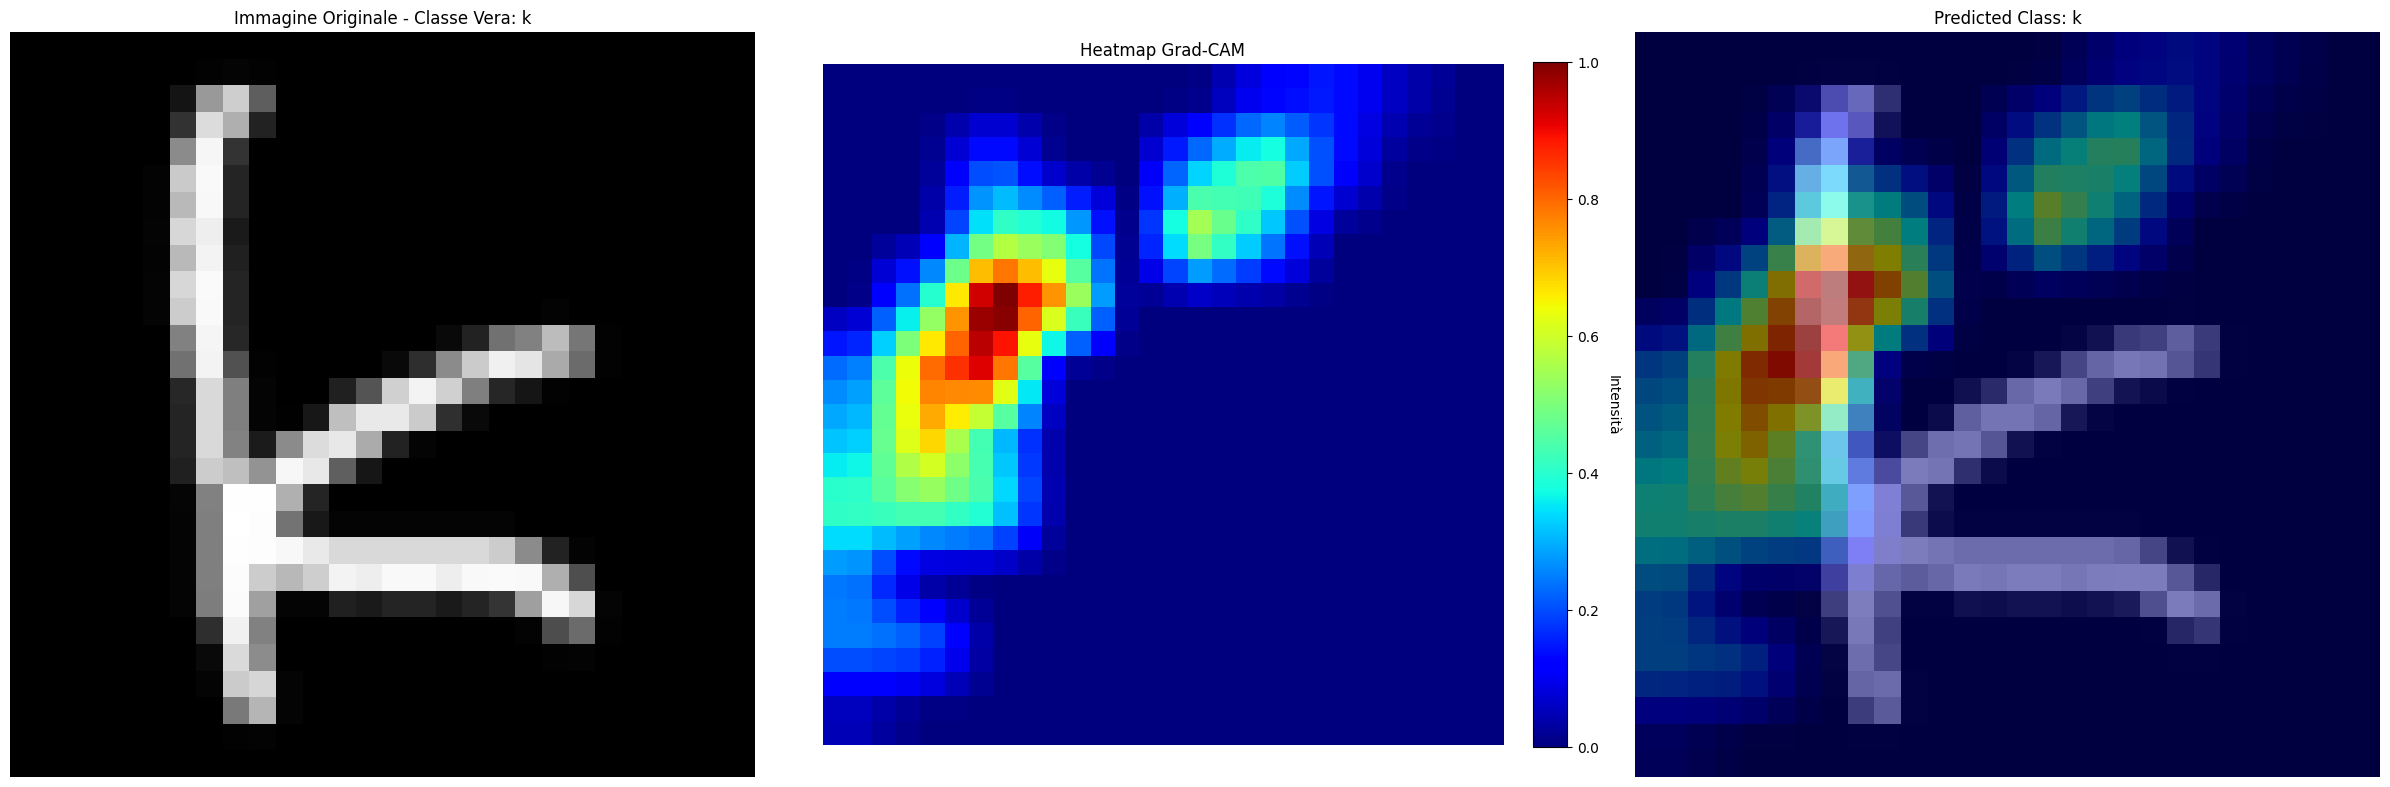

Plots salvati in: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_23.png

Generando Grad-CAM per l'indice: 24


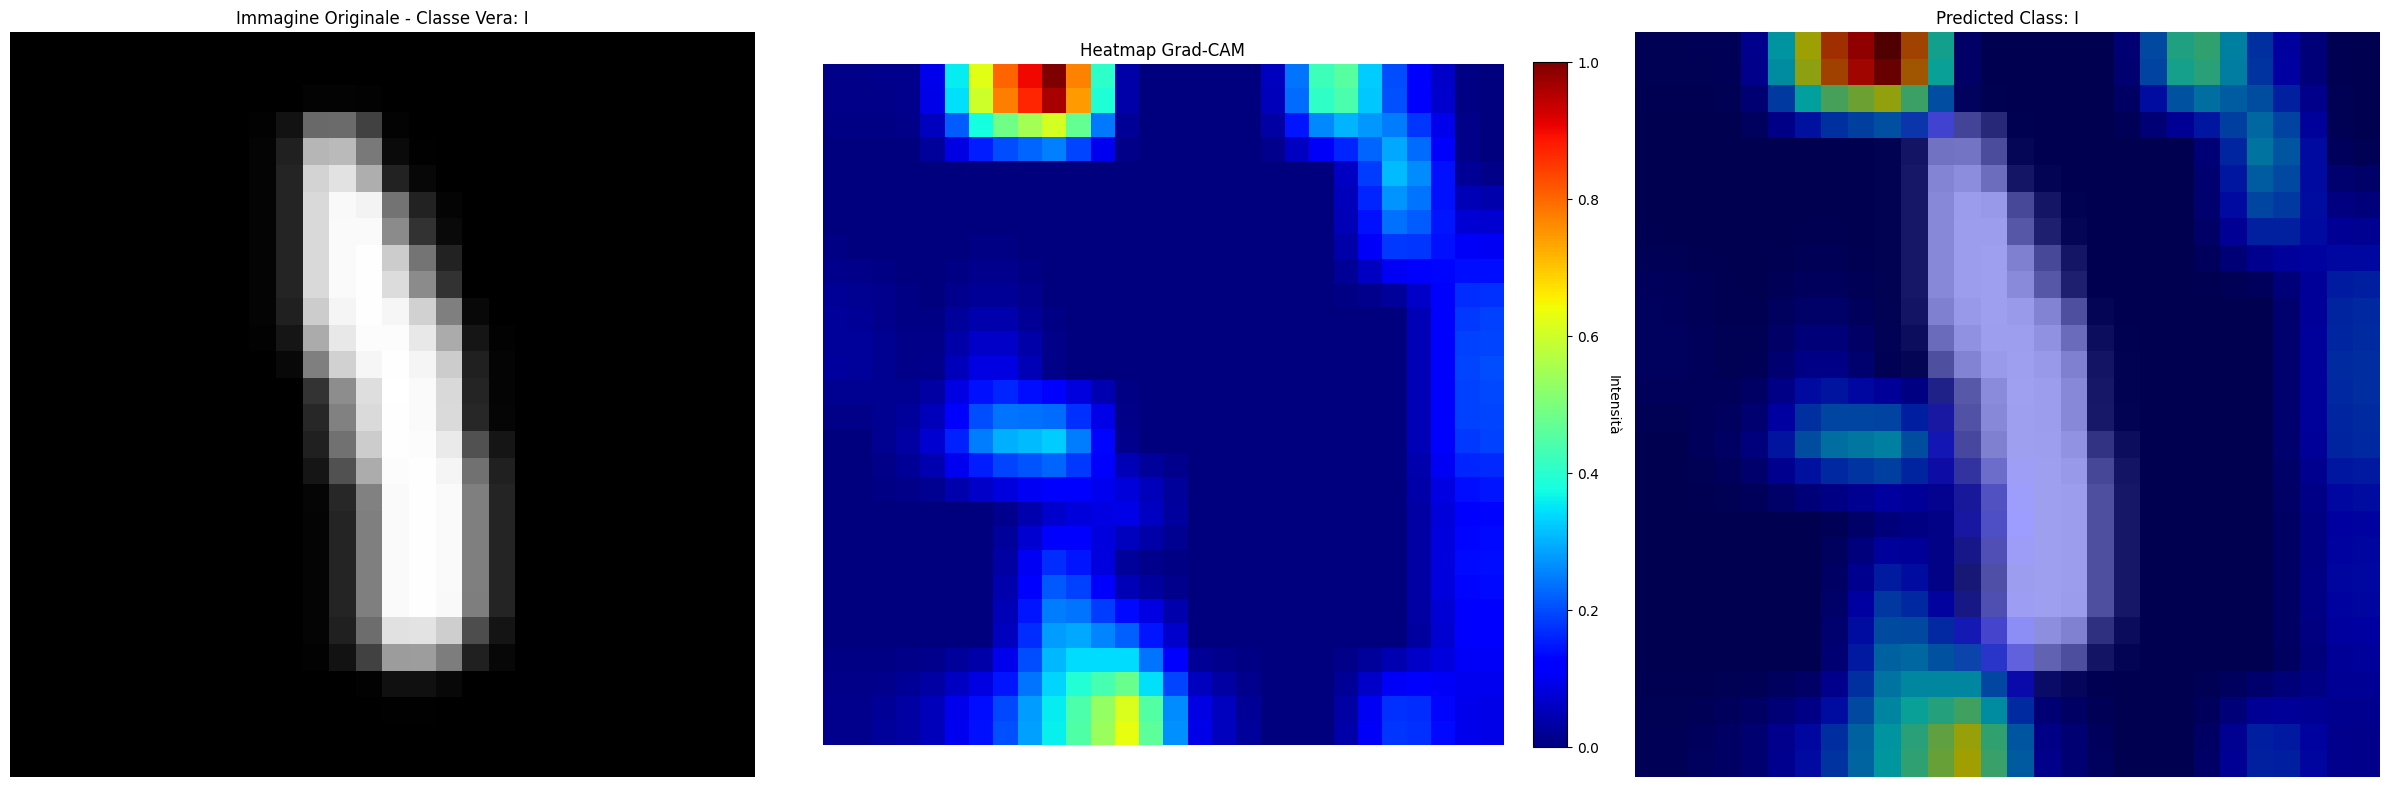

Plots salvati in: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_24.png

Generando Grad-CAM per l'indice: 25


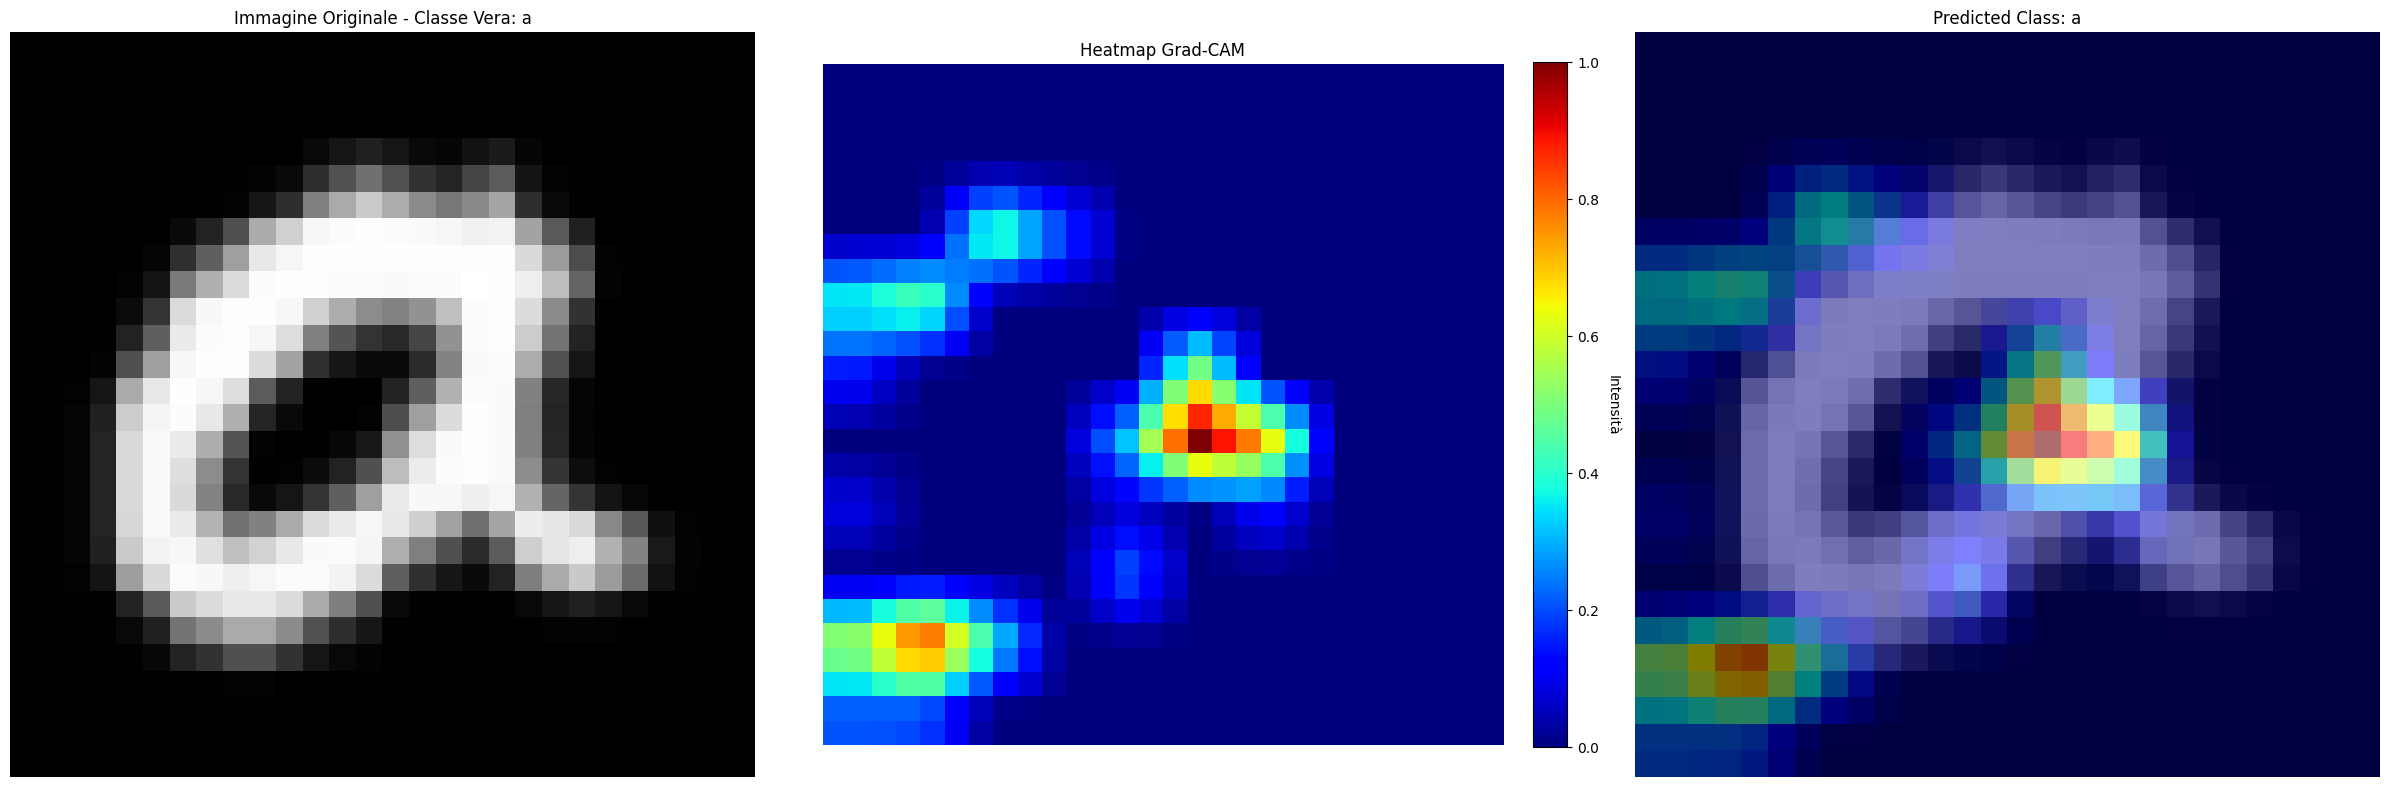

Plots salvati in: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_25.png

Generando Grad-CAM per l'indice: 26


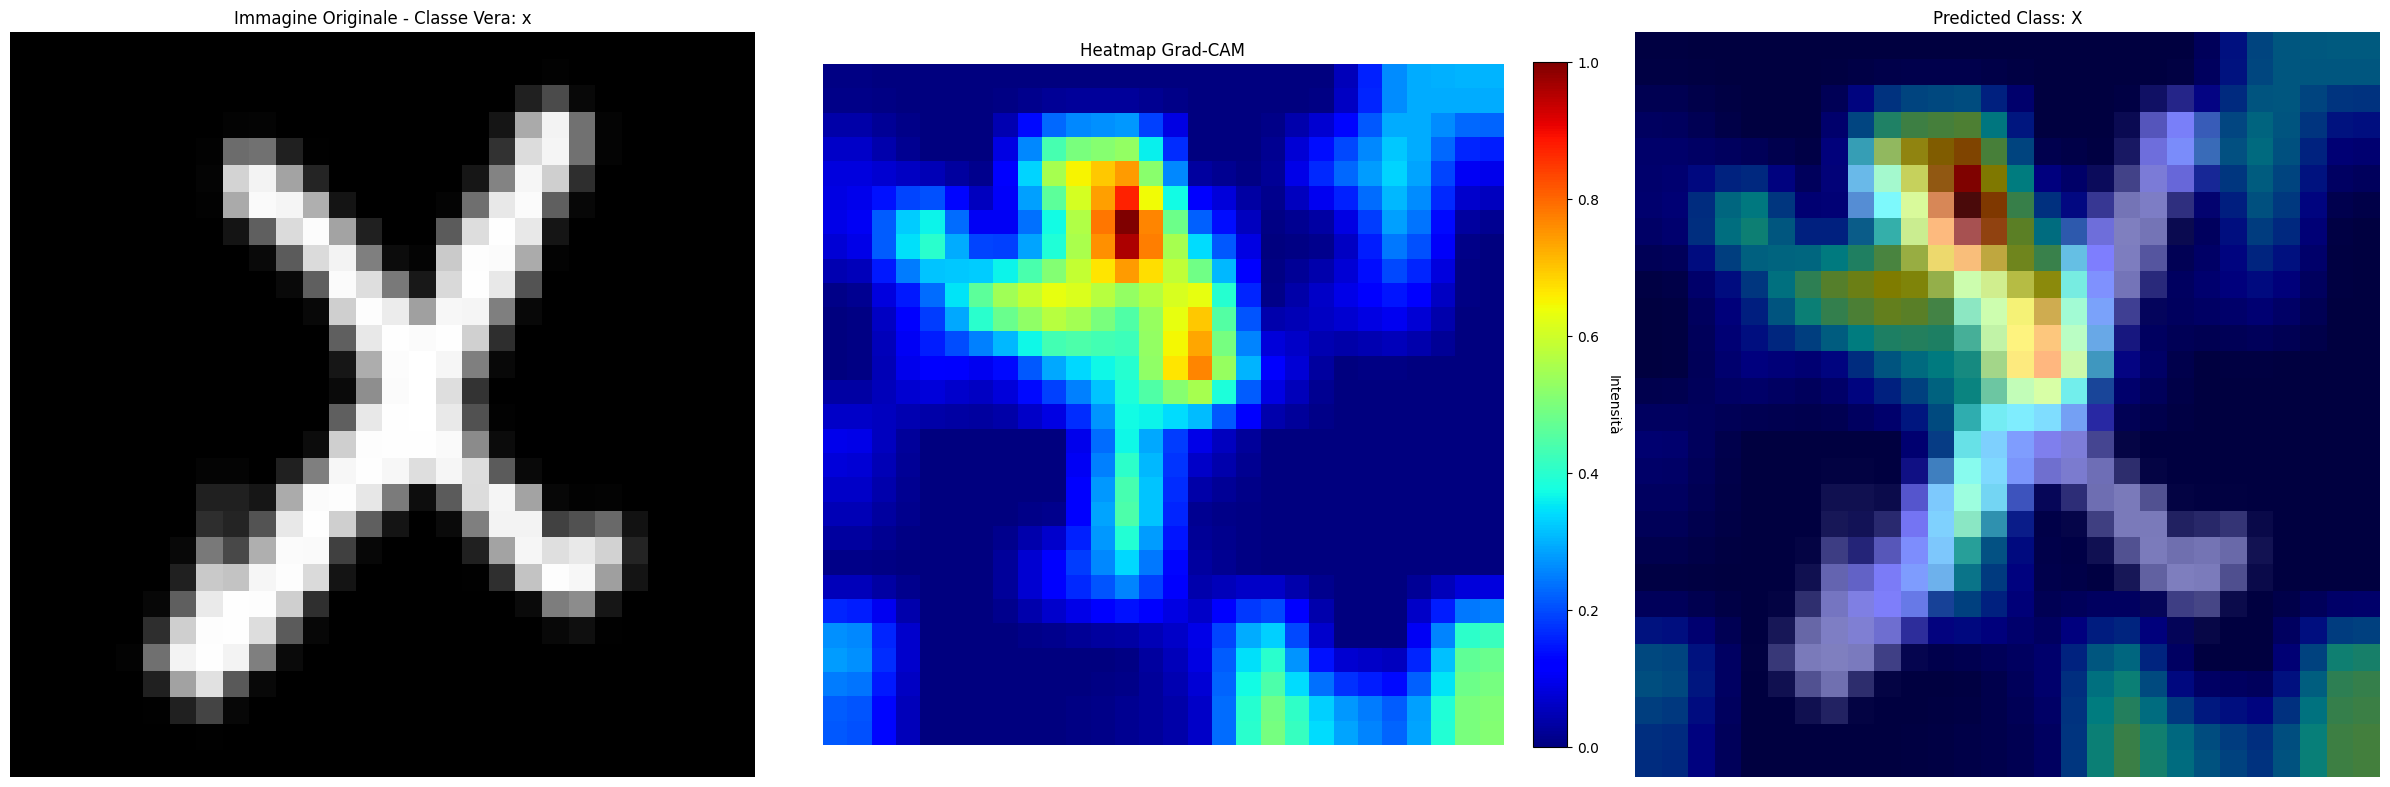

Plots salvati in: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_26.png

Generando Grad-CAM per l'indice: 27


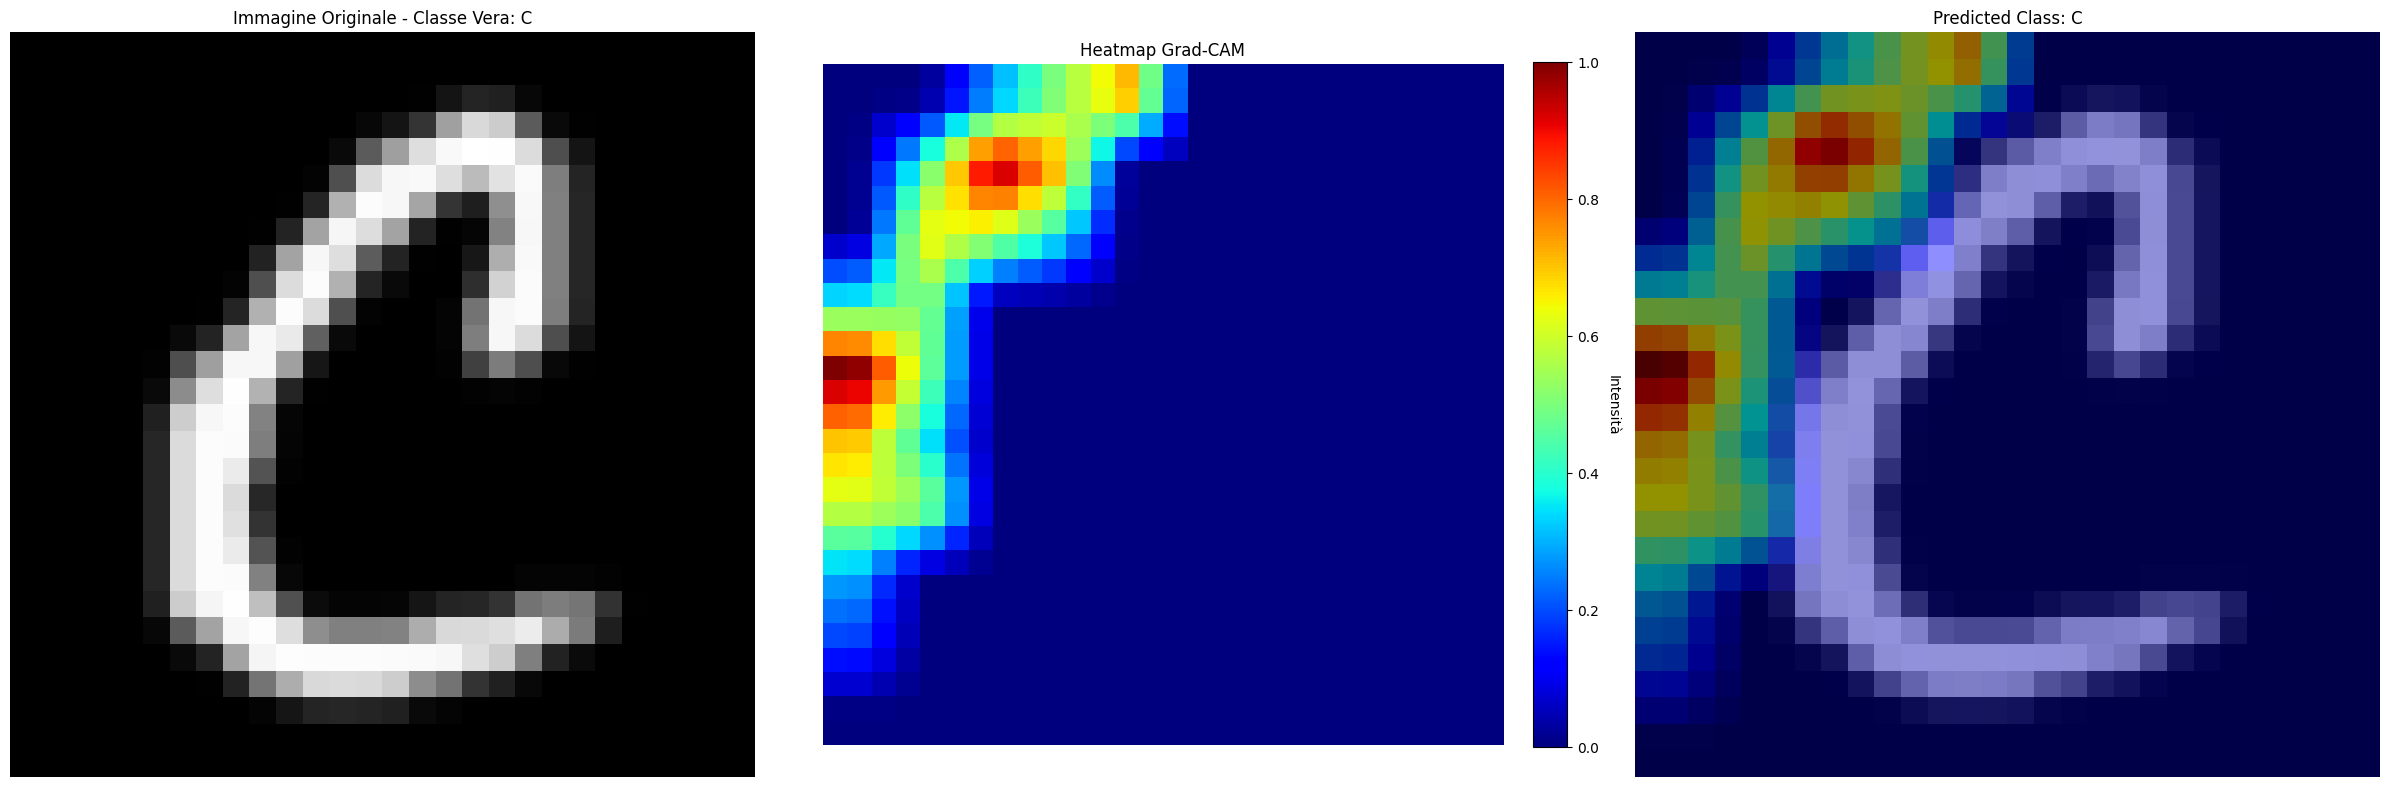

Plots salvati in: results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/gradcam_plots_sample_27.png


In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import struct
import random

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# -------------------------
# Definizione del Modello
# -------------------------

class LeNet5(nn.Module):
    def __init__(self, num_classes=62):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 28x28 -> 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)       # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)             # 14x14 -> 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)       # 10x10 -> 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                   # Flatten
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -------------------------
# Definizione del Dataset in Memoria
# -------------------------

class EMNISTMemoryDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor
        self.labels = labels_tensor

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# -------------------------
# Funzioni per leggere i file IDX
# -------------------------

def read_idx_images(file_path):
    """Legge immagini in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(file_path):
    """Legge etichette in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# -------------------------
# Funzione di Denormalizzazione
# -------------------------

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# -------------------------
# Mappatura delle Classi
# -------------------------

def get_emnist_class_mapping():
    """
    Mappatura delle classi EMNIST ai caratteri corrispondenti.
    EMNIST ByClass ha 62 classi: 0-9, 10-35 A-Z, 36-61 a-z
    """
    characters = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    return {i: char for i, char in enumerate(characters)}

# -------------------------
# Funzione per Estrarre un Campione Specifico
# -------------------------

def get_sample_by_index(dataset, index):
    """
    Estrae un campione specifico dal dataset utilizzando un indice.
    
    Args:
        dataset (Dataset): Il dataset da cui estrarre il campione.
        index (int): L'indice del campione da estrarre.
    
    Returns:
        tuple: (sample_data, sample_target)
    """
    if index < 0 or index >= len(dataset):
        raise IndexError("Indice fuori dal range del dataset.")
    sample_data, sample_target = dataset[index]
    return sample_data.unsqueeze(0), sample_target  # Aggiungi dimensione batch

# -------------------------
# Funzione per Generare e Visualizzare Grad-CAM
# -------------------------

def generate_gradcam_plots(sample_index):
    """
    Genera e visualizza le heatmap Grad-CAM per un campione specifico.
    
    Args:
        sample_index (int): L'indice del campione da analizzare.
    """
    # Verifica che l'indice sia valido
    if sample_index < 0 or sample_index >= len(test_dataset):
        raise IndexError(f"Indice {sample_index} fuori dal range del dataset.")

    # Estrai il campione specifico
    sample_data, sample_target = get_sample_by_index(test_dataset, sample_index)
    sample_data = sample_data.to(device)
    sample_target = sample_target.item()

    # Definisci il target layer
    target_layer = model.conv2

    # Inizializza GradCAM dalla libreria pytorch-grad-cam
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Genera la heatmap Grad-CAM
    grayscale_cam = cam(input_tensor=sample_data, targets=None)  # None = classe predetta
    grayscale_cam = grayscale_cam[0]  # Rimuovi dimensione batch

    # Normalizza la heatmap tra 0 e 1
    grayscale_cam_normalized = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    # Ottieni la classe predetta
    with torch.no_grad():
        output = model(sample_data)
    pred_class = output.argmax(dim=1).item()

    # Denormalizza l'immagine originale per visualizzazione
    original_image = denormalize(sample_data.cpu().clone(), [mean], [std]).squeeze().numpy()

    # Flip orizzontale e rotazione di 90 gradi anti-clockwise
    original_image = np.fliplr(original_image)  # Flip orizzontale
    original_image = np.rot90(original_image, k=1)  # Rotazione di 90 gradi anti-clockwise

    grayscale_cam_normalized = np.fliplr(grayscale_cam_normalized)  # Flip orizzontale della heatmap
    grayscale_cam_normalized = np.rot90(grayscale_cam_normalized, k=1)  # Rotazione di 90 gradi anti-clockwise della heatmap

    # Converti l'immagine originale in RGB e normalizzala tra 0 e 1
    original_image_rgb = np.stack([original_image]*3, axis=2)  # [H, W, 3]
    original_image_rgb = original_image_rgb / 255.0  # Assicurati che l'immagine sia tra 0 e 1

    # Usa show_cam_on_image per sovrapporre la cam
    visualization = show_cam_on_image(original_image_rgb, grayscale_cam_normalized, use_rgb=True)

    # Crea una figura con 3 subplot
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))

    # Plot 1: Immagine Originale
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title(f"Immagine Originale - Classe Vera: {class_mapping[sample_target]}")
    axs[0].axis('off')

    # Plot 2: Heatmap Grad-CAM Isolata
    im = axs[1].imshow(grayscale_cam_normalized, cmap='jet')
    axs[1].set_title("Heatmap Grad-CAM")
    axs[1].axis('off')
    # Aggiungi una barra laterale (colorbar)
    cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Intensità', rotation=270, labelpad=15)

    # Plot 3: Immagine con Heatmap Sovrapposta
    axs[2].imshow(visualization)
    axs[2].set_title(f"Predicted Class: {class_mapping[pred_class]}")
    axs[2].axis('off')

    # Salva e mostra la figura completa
    plt.tight_layout()
    save_path = os.path.join(base_dir, f'gradcam_plots_sample_{sample_index}.png')
    plt.savefig(save_path)
    plt.show()

    print(f"Plots salvati in: {save_path}")

    # Pulisci i hook dopo aver finito
    cam = None  # Libera risorse (GradCAM chiama automaticamente remove hooks nel suo metodo __del__)

# -------------------------
# Funzione Principale
# -------------------------

def main():
    global model, test_dataset, class_mapping, mean, std, base_dir, device

    # Impostazione dei parametri fissi
    learning_rate = 0.01
    optimizer_type = "SGD"
    grid_size = 0
    spline_order = 0
    norm_type = "L2"
    num_of_classes = 62
    batch_size = 1

    # Seme per riproducibilità
    seed = 12
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')

    mean, std = 0.1307, 0.3081

    data_dir = '/home/magliolo/.cache/emnist/gzip/'

    base_dir = os.path.join(
        'results',
        f"results_{norm_type}_{optimizer_type}_lr{learning_rate}_{grid_size}_{spline_order}",
        'Standard_LeNet5'
    )
    model_dir = os.path.join(base_dir, "model")

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Directory del modello non trovata: {model_dir}")

    model = LeNet5(num_classes=num_of_classes).to(device)

    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    if not checkpoints:
        raise FileNotFoundError(f"Nessun checkpoint trovato nella directory: {model_dir}")
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(model_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint caricato: {checkpoint_path}, Epoch: {checkpoint['epoch']}")
    model.eval()

    # Leggi i dati di test
    test_images_path = os.path.join(data_dir, 'emnist-byclass-test-images-idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 'emnist-byclass-test-labels-idx1-ubyte')

    print("Leggendo i dati di test...")
    images_test = read_idx_images(test_images_path)
    labels_test = read_idx_labels(test_labels_path)

    # Converti in Tensori e normalizza
    test_images_tensor = torch.from_numpy(images_test.copy()).unsqueeze(1).float()
    test_labels_tensor = torch.from_numpy(labels_test.copy()).long()

    # Normalizzazione
    test_images_tensor = (test_images_tensor - mean) / std

    # Sposta su GPU
    test_images_tensor = test_images_tensor.to(device)
    test_labels_tensor = test_labels_tensor.to(device)

    # Crea il dataset in memoria
    test_dataset = EMNISTMemoryDataset(test_images_tensor, test_labels_tensor)

    # Crea il DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Test size: {len(test_loader.dataset)}")
    print(f"Numero di classi uniche nel dataset di test: {len(set(labels_test))}")
    print(f"Etichette uniche nel dataset di test: {sorted(set(labels_test))}")

    # Mappatura delle classi
    class_mapping = get_emnist_class_mapping()

    # Ora puoi chiamare la funzione `generate_gradcam_plots` con l'indice desiderato
    # Esempio:
    sample_indices = [9, 15, 23, 24, 25, 26, 27]  # Puoi aggiungere altri indici qui

    for sample_index in sample_indices:
        print(f"\nGenerando Grad-CAM per l'indice: {sample_index}")
        try:
            generate_gradcam_plots(sample_index)
        except Exception as e:
            print(f"Errore nella generazione della heatmap per l'indice {sample_index}: {e}")

if __name__ == "__main__":
    main()


Device: cuda
Checkpoint caricato: results/results_None_SGD_lr0.01_5_3/KaNet5/model/checkpoint_epoch_50.pth, Epoch: 50
Leggendo i dati di test...
Test size: 116323
Numero di classi uniche nel dataset di test: 62
Etichette uniche nel dataset di test: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

Generando Grad-CAM per l'indice: 9


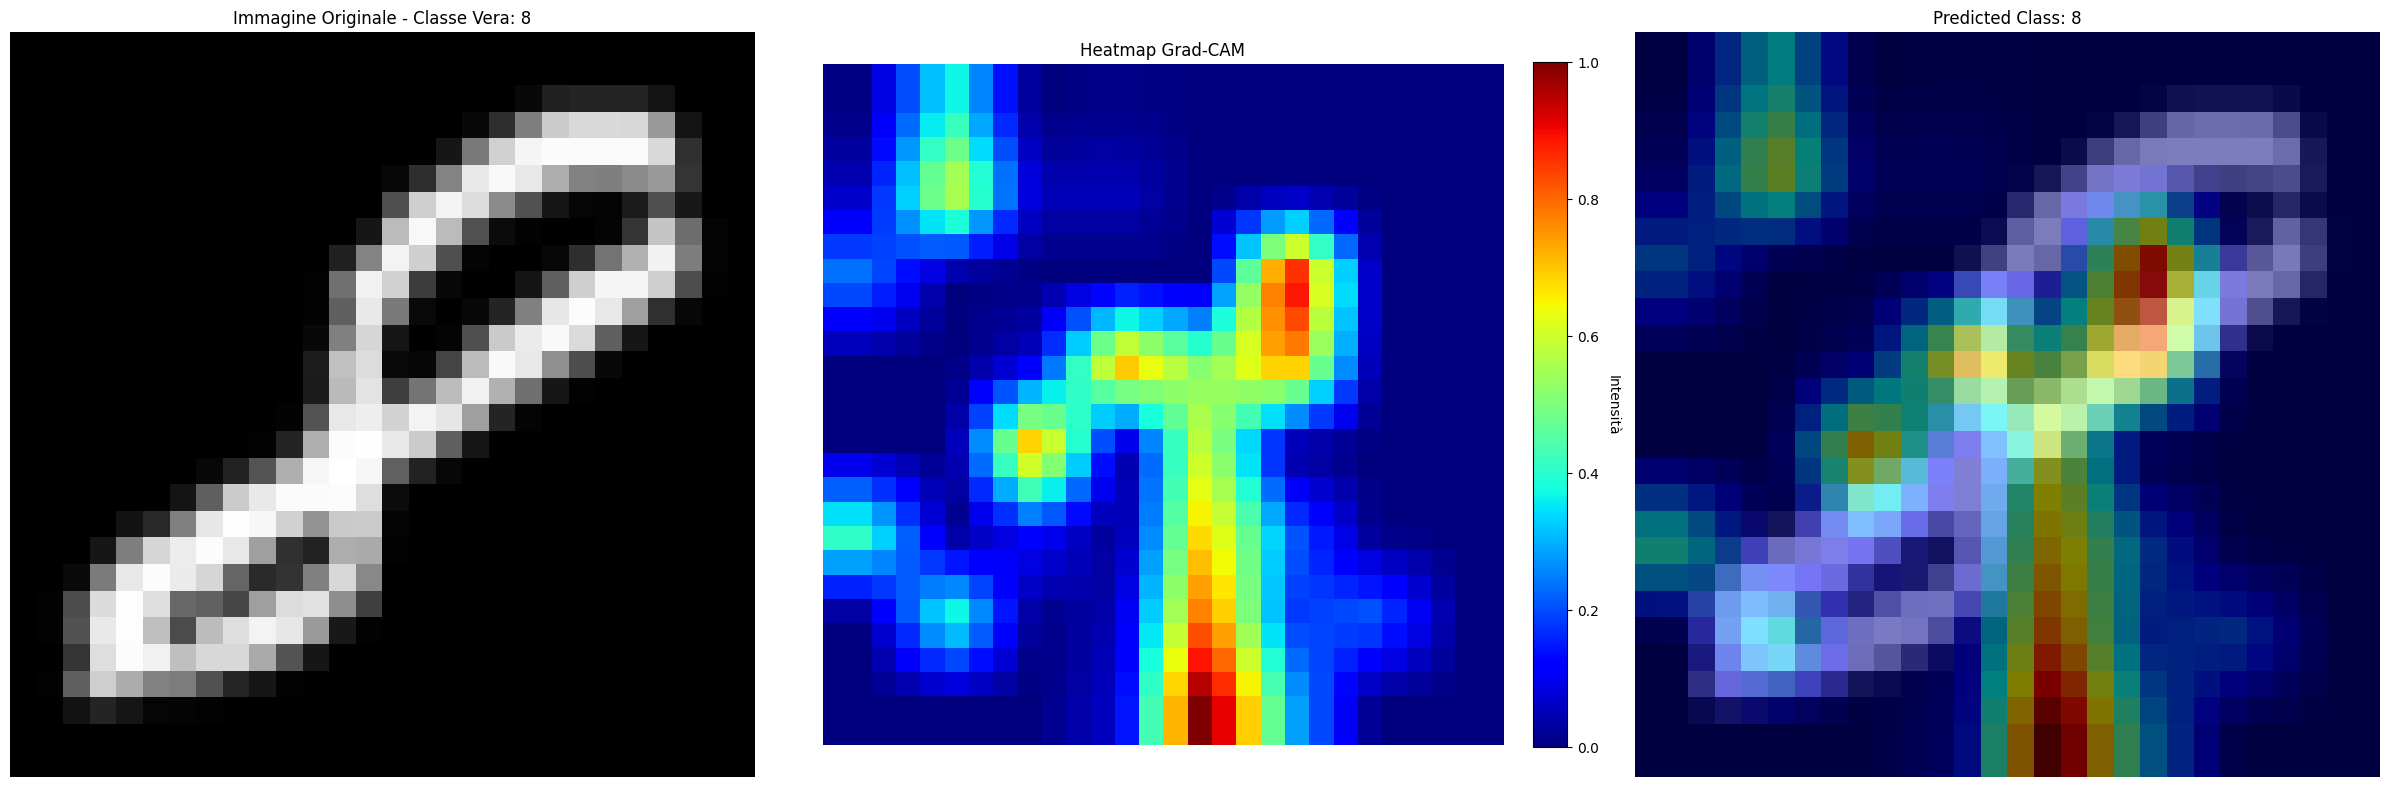

Plots salvati in: results/results_None_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_9.png

Generando Grad-CAM per l'indice: 15


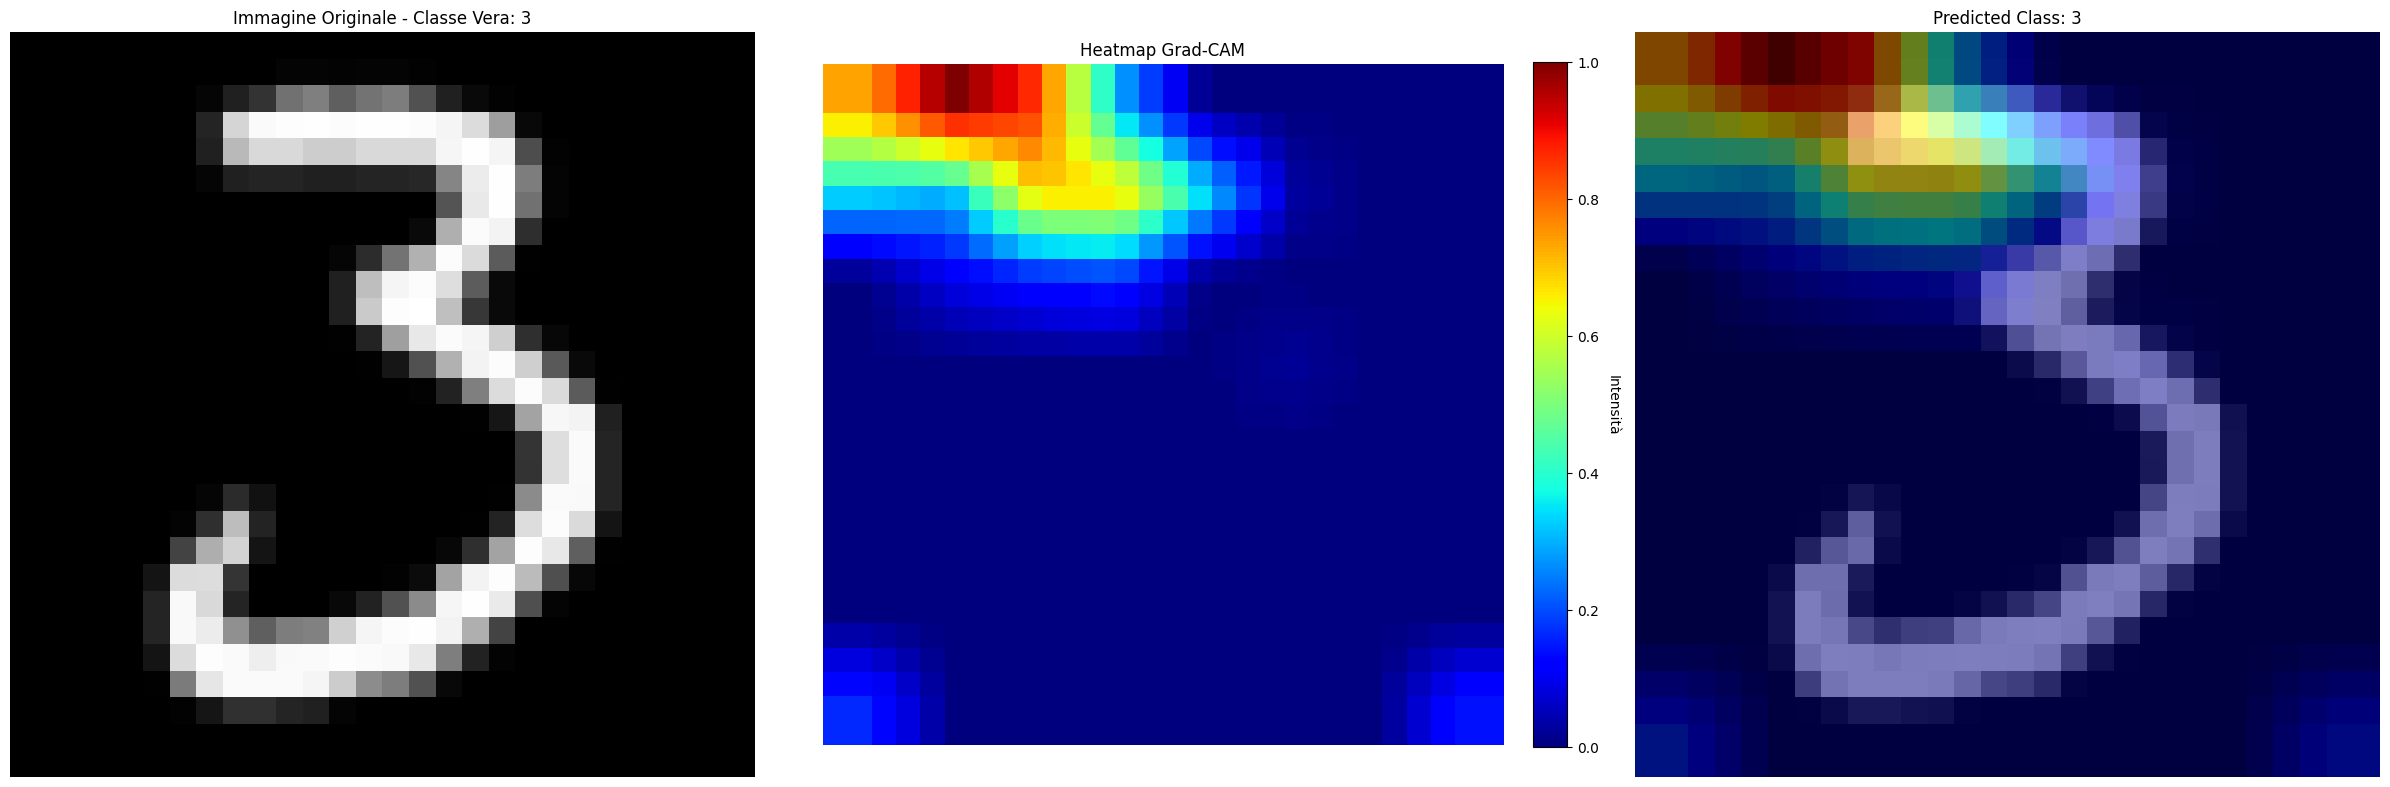

Plots salvati in: results/results_None_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_15.png

Generando Grad-CAM per l'indice: 23


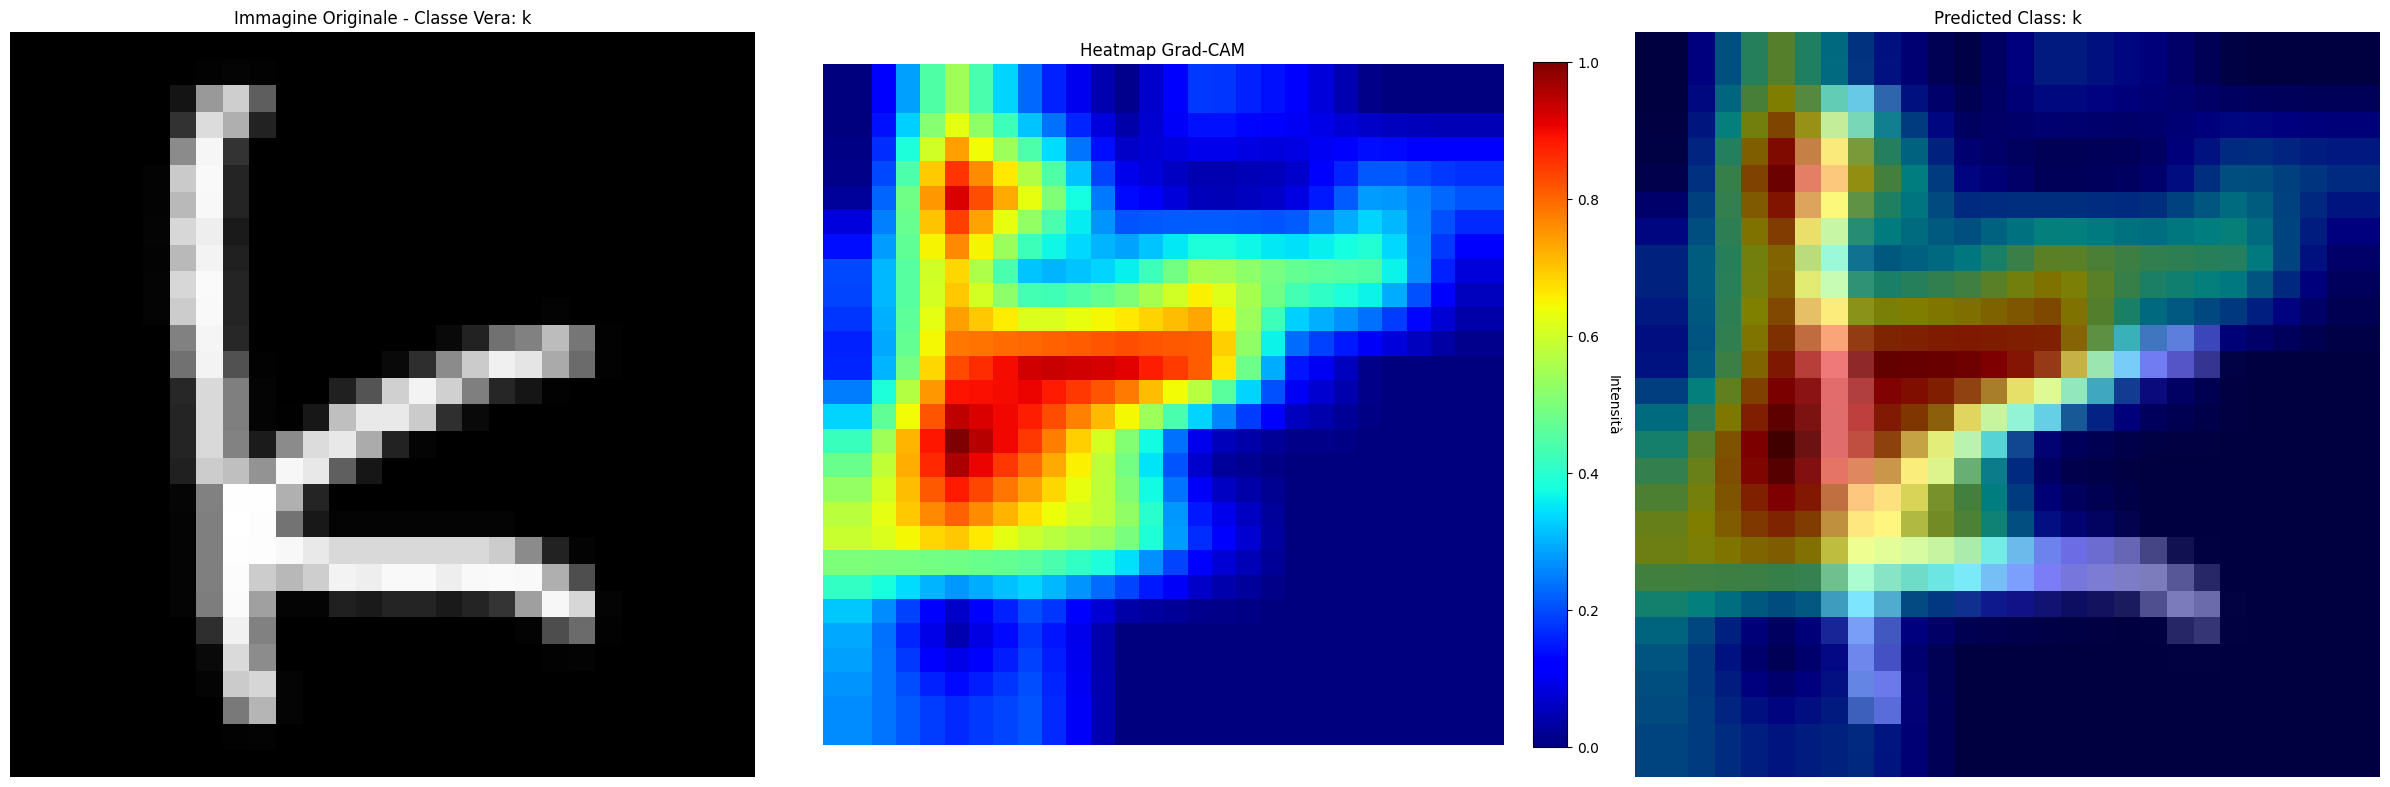

Plots salvati in: results/results_None_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_23.png

Generando Grad-CAM per l'indice: 24


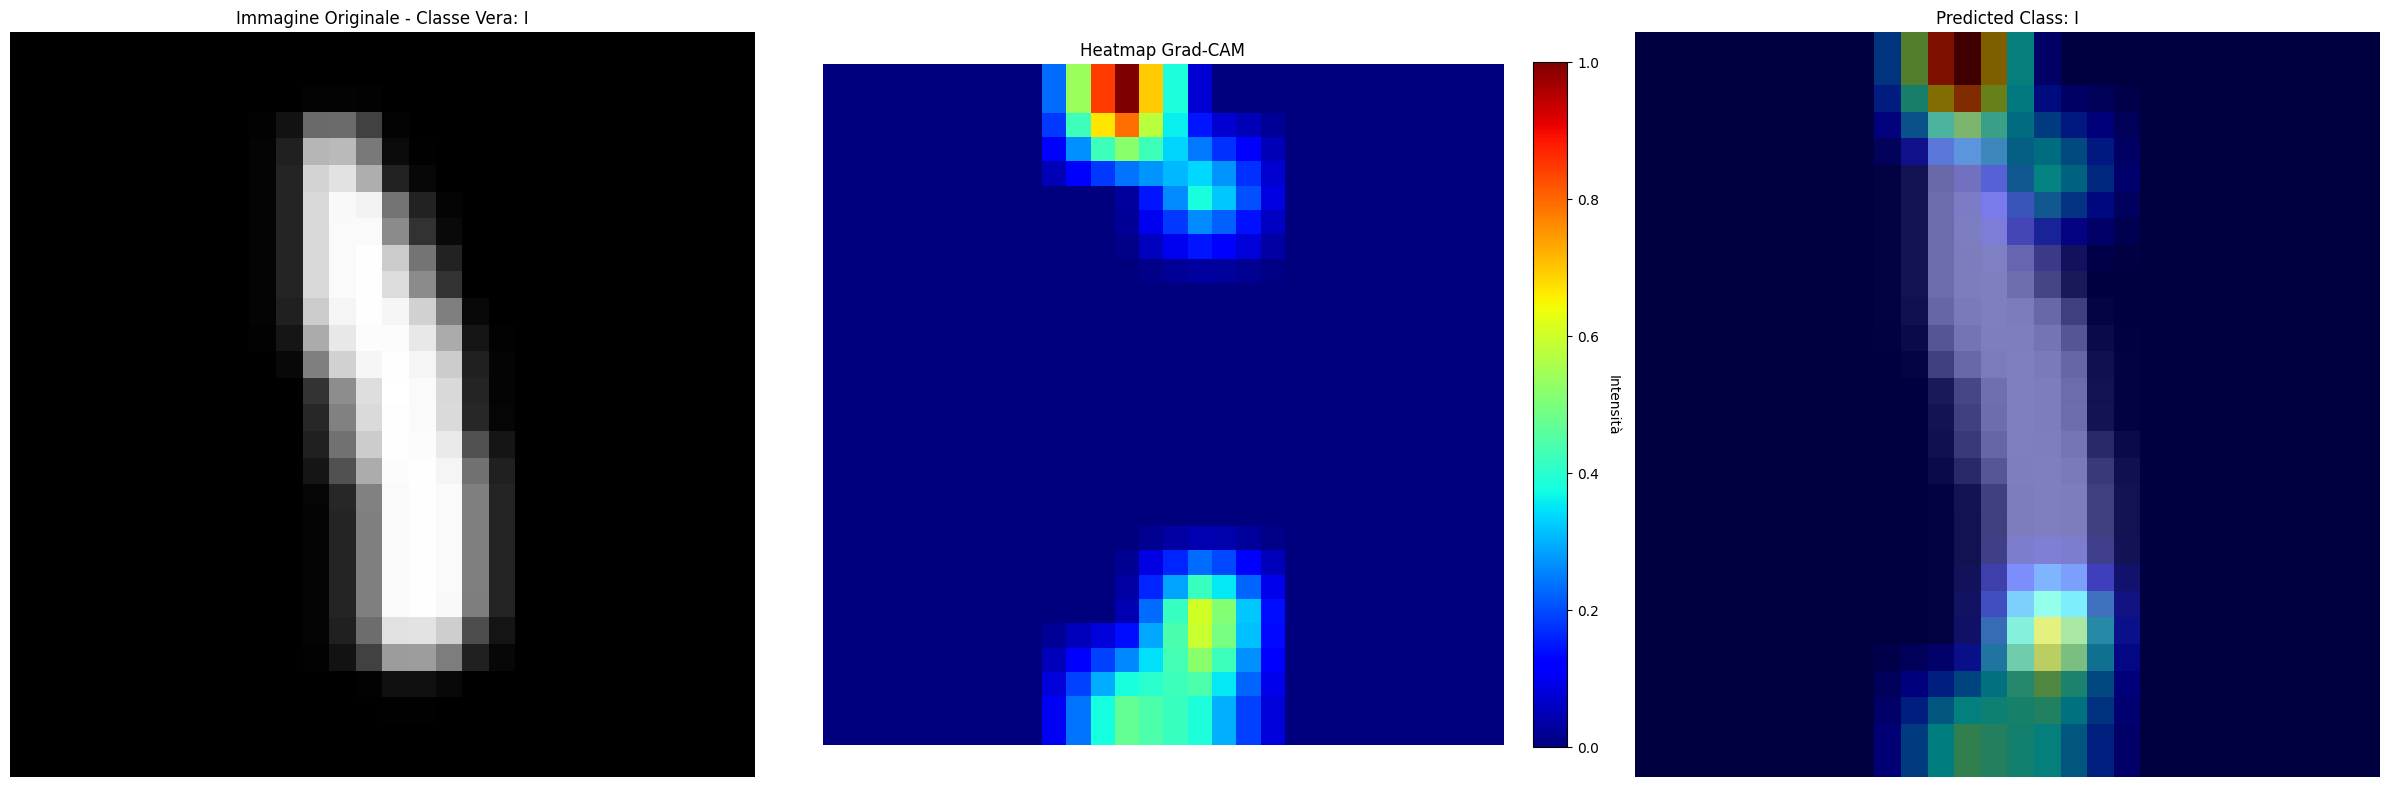

Plots salvati in: results/results_None_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_24.png

Generando Grad-CAM per l'indice: 25


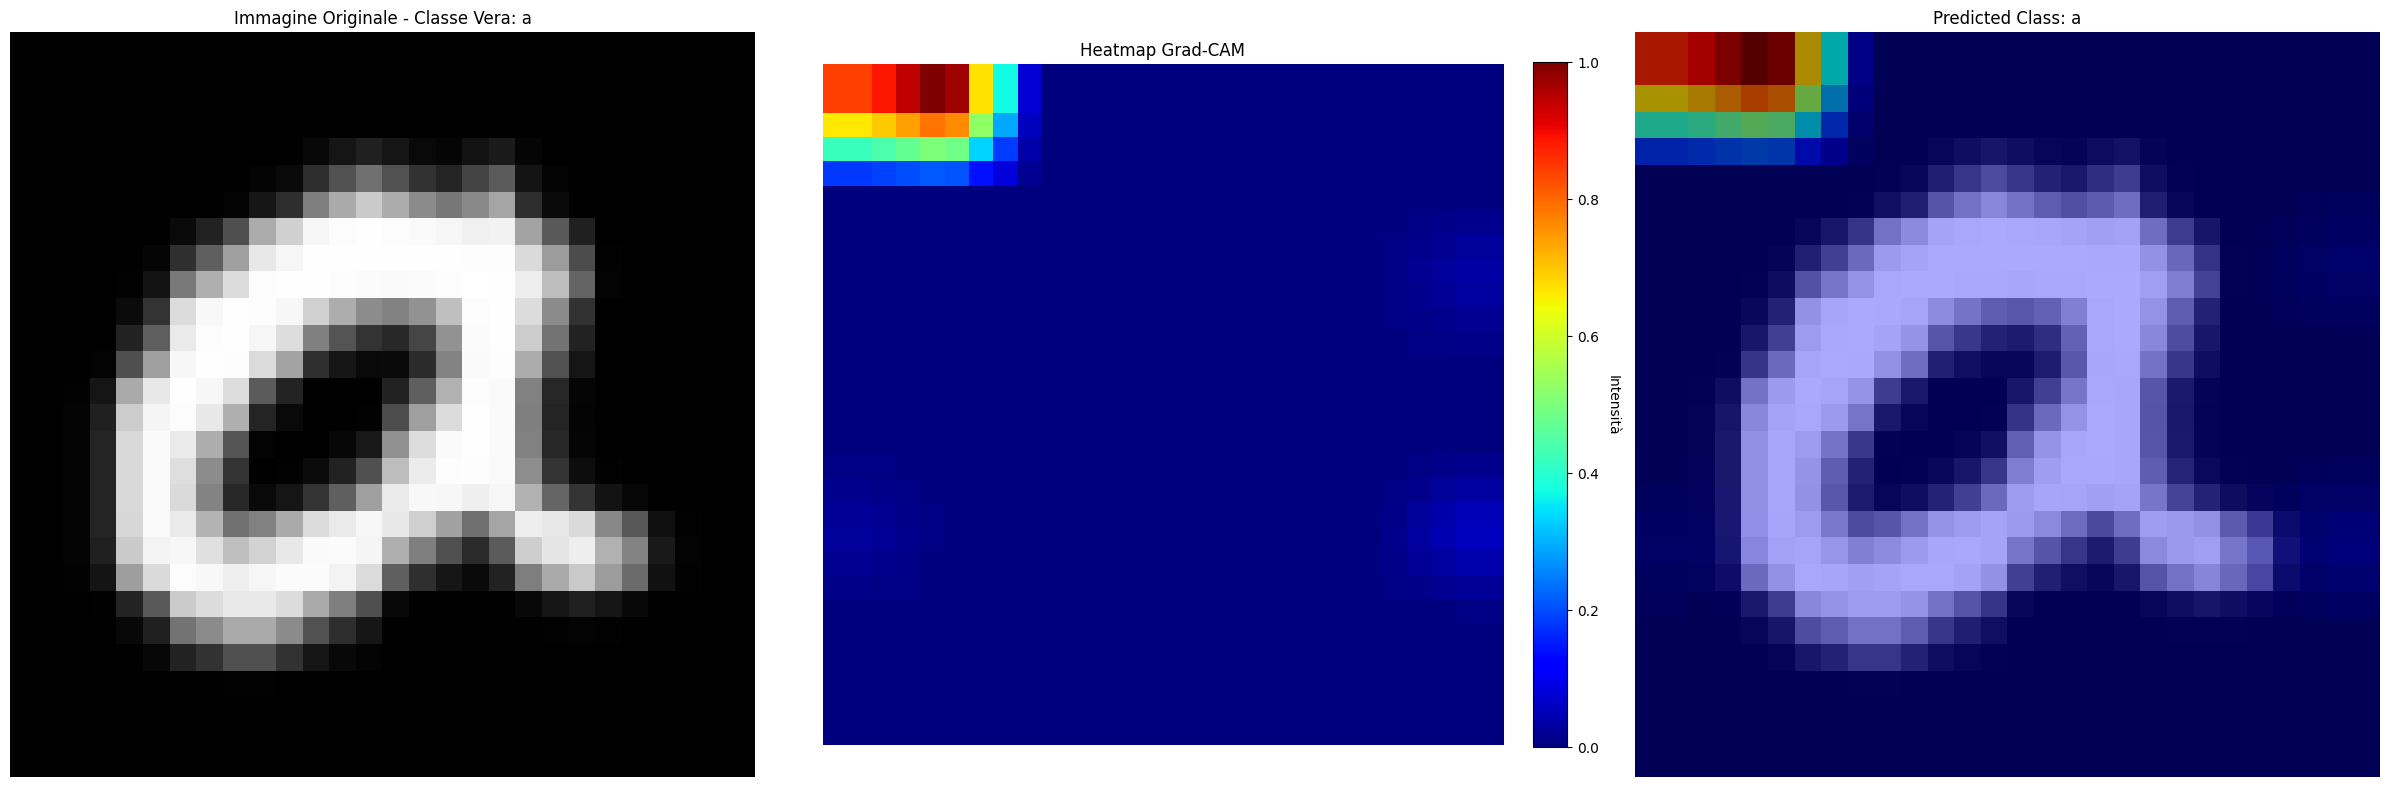

Plots salvati in: results/results_None_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_25.png

Generando Grad-CAM per l'indice: 26


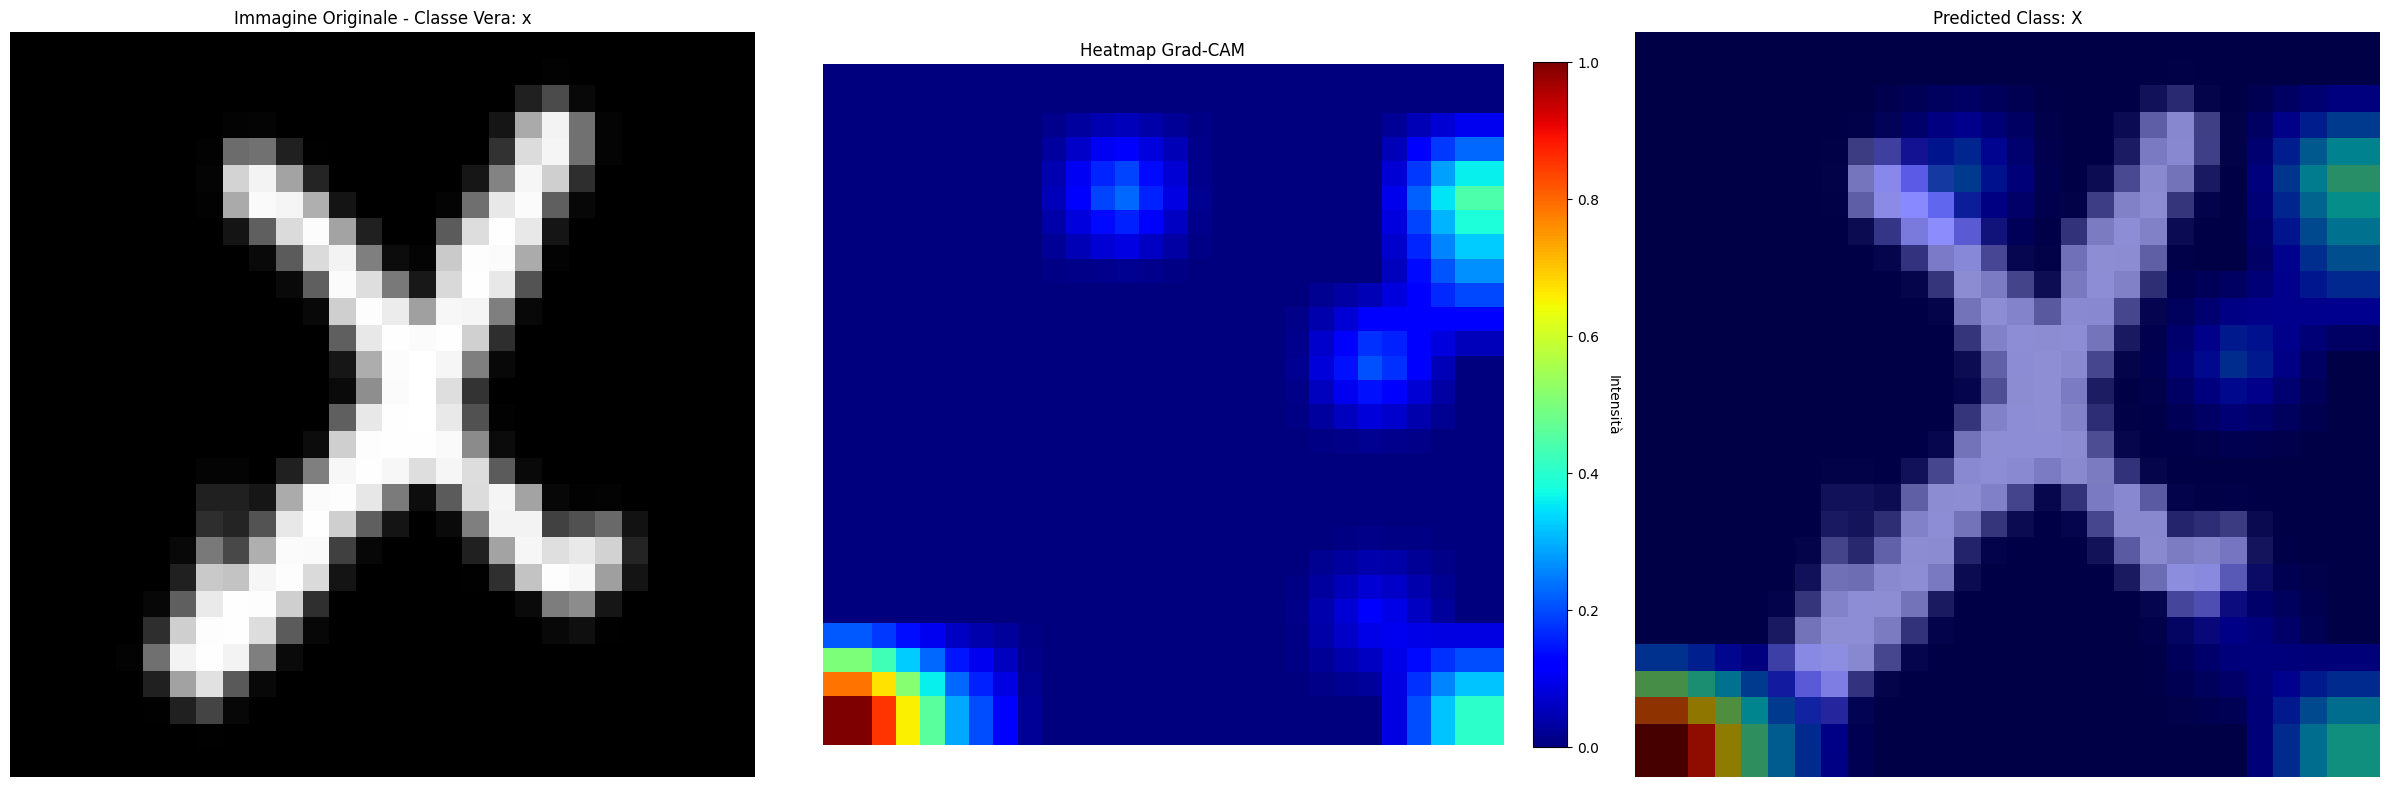

Plots salvati in: results/results_None_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_26.png

Generando Grad-CAM per l'indice: 27


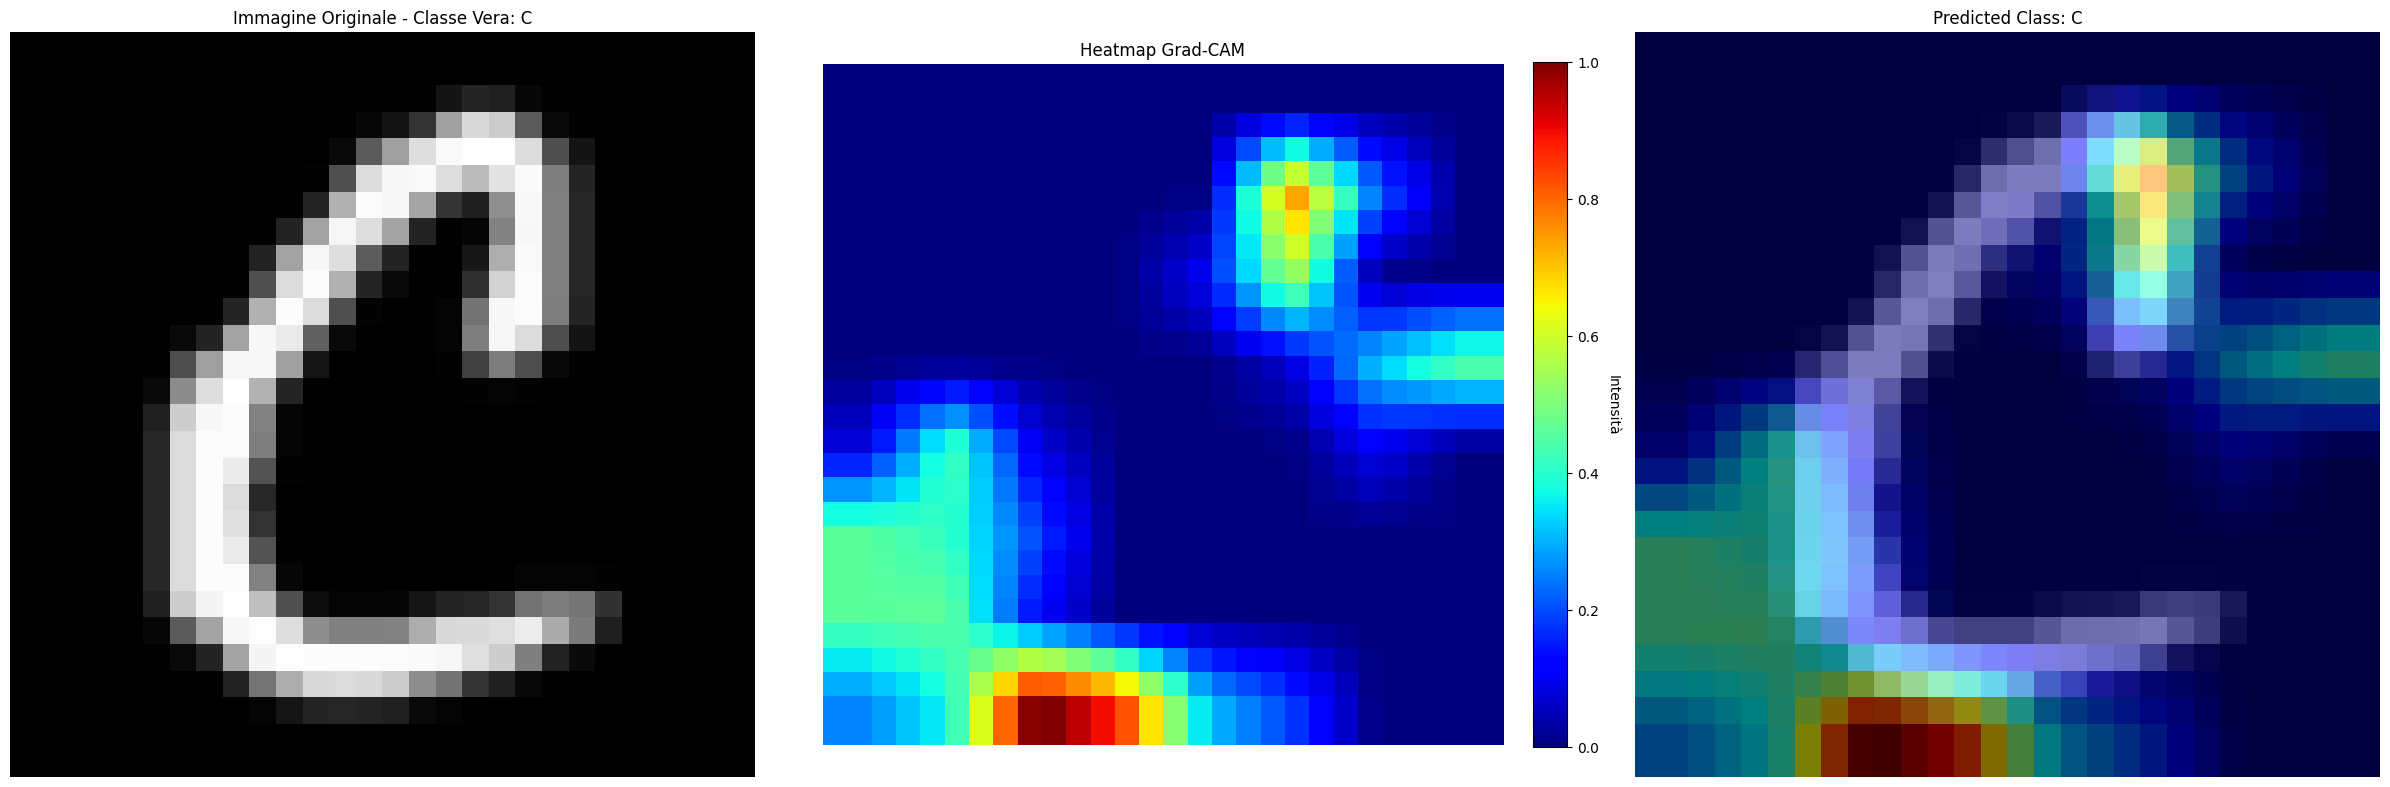

Plots salvati in: results/results_None_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_27.png


In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import struct
import random

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# -------------------------
# Definizione del Modello KAN
# -------------------------

from kan_convolutional.KANLinear import KANLinear
import kan_convolutional.convolution
from kan_convolutional.KANConv import KAN_Convolutional_Layer

class LeNet5_KAN(nn.Module):
    def __init__(self, num_classes=62):  # EMNIST Balanced ha 62 classi
        super(LeNet5_KAN, self).__init__()
        
        # Primo strato conv: input=1 canale, output=6 filtri, kernel=5x5
        self.conv1 = KAN_Convolutional_Layer(
            in_channels=1,
            out_channels=6,
            kernel_size=(5,5),
            stride=(1,1),
            padding=(0,0),
            dilation=(1,1),
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.ReLU,
            grid_eps=0.02,
            grid_range=(-1, 1)
        )
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Secondo strato conv: input=6 canali, output=16 filtri, kernel=5x5
        self.conv2 = KAN_Convolutional_Layer(
            in_channels=6,
            out_channels=16,
            kernel_size=(5,5),
            stride=(1,1),
            padding=(0,0),
            dilation=(1,1),
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.ReLU,
            grid_eps=0.02,
            grid_range=(-1, 1)
        )
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Dopo conv1+pool1 (28x28 -> conv5x5->24x24 -> pool->12x12)
        # Dopo conv2+pool2 (12x12 -> conv5x5->8x8 -> pool->4x4)
        # 16 canali da 4x4 => 16*4*4=256
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  

    def forward(self, x):
        # Passo 1: conv + pooling
        x = self.conv1(x)
        x = self.pool1(x)
        
        # Passo 2: conv + pooling
        x = self.conv2(x)
        x = self.pool2(x)
        
        # Flatten
        x = x.contiguous().view(x.size(0), -1)

        # Fully Connected Layers con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output Layer (senza attivazione)
        x = self.fc3(x)
        return x


# -------------------------
# Definizione del Dataset in Memoria
# -------------------------

class EMNISTMemoryDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor
        self.labels = labels_tensor

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# -------------------------
# Funzioni per leggere i file IDX
# -------------------------

def read_idx_images(file_path):
    """Legge immagini in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(file_path):
    """Legge etichette in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# -------------------------
# Funzione di Denormalizzazione
# -------------------------

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# -------------------------
# Mappatura delle Classi
# -------------------------

def get_emnist_class_mapping():
    characters = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    return {i: char for i, char in enumerate(characters)}

# -------------------------
# Funzione per Estrarre un Campione Specifico
# -------------------------

def get_sample_by_index(dataset, index):
    if index < 0 or index >= len(dataset):
        raise IndexError("Indice fuori dal range del dataset.")
    sample_data, sample_target = dataset[index]
    return sample_data.unsqueeze(0), sample_target  # Aggiungi dimensione batch

# -------------------------
# Funzione per Generare e Visualizzare Grad-CAM
# -------------------------

def generate_gradcam_plots(sample_index):
    if sample_index < 0 or sample_index >= len(test_dataset):
        raise IndexError(f"Indice {sample_index} fuori dal range del dataset.")

    sample_data, sample_target = get_sample_by_index(test_dataset, sample_index)
    sample_data = sample_data.to(device)
    sample_target = sample_target.item()

    # Definisci il target layer della KAN convoluzionale (ad esempio conv2)
    target_layer = model.conv2

    # Inizializza GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Genera la heatmap Grad-CAM
    grayscale_cam = cam(input_tensor=sample_data, targets=None)
    grayscale_cam = grayscale_cam[0]

    grayscale_cam_normalized = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    with torch.no_grad():
        output = model(sample_data)
    pred_class = output.argmax(dim=1).item()

    original_image = denormalize(sample_data.cpu().clone(), [mean], [std]).squeeze().numpy()

    # Flip orizzontale e rotazione di 90 gradi anti-clockwise
    original_image = np.fliplr(original_image)
    original_image = np.rot90(original_image, k=1)

    grayscale_cam_normalized = np.fliplr(grayscale_cam_normalized)
    grayscale_cam_normalized = np.rot90(grayscale_cam_normalized, k=1)

    # Converti l'immagine originale in RGB e normalizzala tra 0 e 1
    original_image_rgb = np.stack([original_image]*3, axis=2)
    original_image_rgb = original_image_rgb / 255.0

    visualization = show_cam_on_image(original_image_rgb, grayscale_cam_normalized, use_rgb=True)

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title(f"Immagine Originale - Classe Vera: {class_mapping[sample_target]}")
    axs[0].axis('off')

    im = axs[1].imshow(grayscale_cam_normalized, cmap='jet')
    axs[1].set_title("Heatmap Grad-CAM")
    axs[1].axis('off')
    cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Intensità', rotation=270, labelpad=15)

    axs[2].imshow(visualization)
    axs[2].set_title(f"Predicted Class: {class_mapping[pred_class]}")
    axs[2].axis('off')

    plt.tight_layout()
    save_path = os.path.join(base_dir, f'gradcam_plots_sample_{sample_index}.png')
    plt.savefig(save_path)
    plt.show()

    print(f"Plots salvati in: {save_path}")

    cam = None  # Libera risorse

# -------------------------
# Funzione Principale
# -------------------------

def main():
    global model, test_dataset, class_mapping, mean, std, base_dir, device

    # Impostazioni
    learning_rate = 0.01
    optimizer_type = "SGD"
    grid_size = 5
    spline_order = 3
    norm_type = "None"
    num_of_classes = 62
    batch_size = 1

    seed = 12
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')

    mean, std = 0.1307, 0.3081

    data_dir = '/home/magliolo/.cache/emnist/gzip/'

    base_dir = os.path.join(
        'results',
        f"results_{norm_type}_{optimizer_type}_lr{learning_rate}_{grid_size}_{spline_order}",
        'KaNet5'
    )
    model_dir = os.path.join(base_dir, "model")

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Directory del modello non trovata: {model_dir}")

    # Utilizzo del modello KAN invece del classico LeNet5
    model = LeNet5_KAN(num_classes=num_of_classes).to(device)

    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    if not checkpoints:
        raise FileNotFoundError(f"Nessun checkpoint trovato nella directory: {model_dir}")
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(model_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint caricato: {checkpoint_path}, Epoch: {checkpoint['epoch']}")
    model.eval()

    # Leggi i dati di test
    test_images_path = os.path.join(data_dir, 'emnist-byclass-test-images-idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 'emnist-byclass-test-labels-idx1-ubyte')

    print("Leggendo i dati di test...")
    images_test = read_idx_images(test_images_path)
    labels_test = read_idx_labels(test_labels_path)

    test_images_tensor = torch.from_numpy(images_test.copy()).unsqueeze(1).float()
    test_labels_tensor = torch.from_numpy(labels_test.copy()).long()

    test_images_tensor = (test_images_tensor - mean) / std

    test_images_tensor = test_images_tensor.to(device)
    test_labels_tensor = test_labels_tensor.to(device)

    test_dataset = EMNISTMemoryDataset(test_images_tensor, test_labels_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Test size: {len(test_loader.dataset)}")
    print(f"Numero di classi uniche nel dataset di test: {len(set(labels_test))}")
    print(f"Etichette uniche nel dataset di test: {sorted(set(labels_test))}")

    class_mapping = get_emnist_class_mapping()

    # Indici di esempio
    sample_indices = [9, 15, 23, 24, 25, 26, 27]

    for sample_index in sample_indices:
        print(f"\nGenerando Grad-CAM per l'indice: {sample_index}")
        try:
            generate_gradcam_plots(sample_index)
        except Exception as e:
            print(f"Errore nella generazione della heatmap per l'indice {sample_index}: {e}")

if __name__ == "__main__":
    main()


Device: cuda
Checkpoint caricato: results/results_L2_SGD_lr0.01_5_3/KaNet5/model/checkpoint_epoch_50.pth, Epoch: 50
Leggendo i dati di test...
Test size: 116323
Numero di classi uniche nel dataset di test: 62
Etichette uniche nel dataset di test: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

Generando Grad-CAM per l'indice: 9


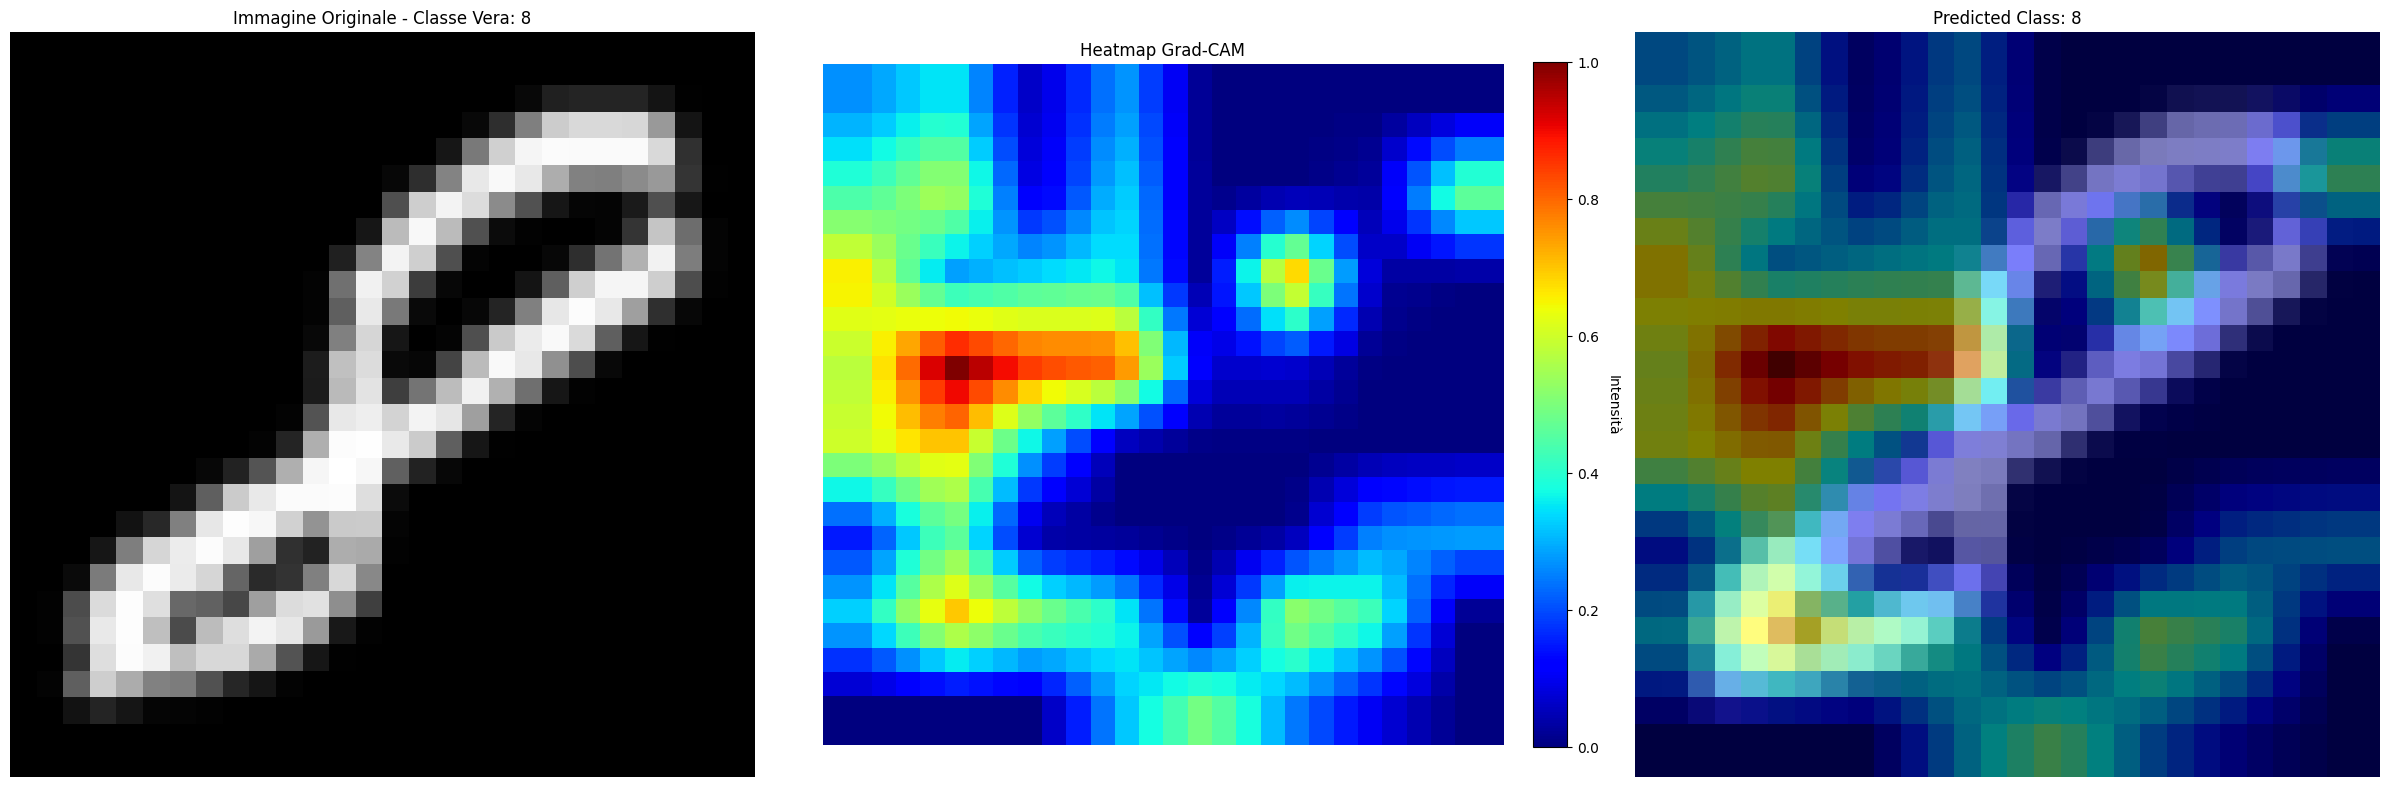

Plots salvati in: results/results_L2_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_9.png

Generando Grad-CAM per l'indice: 15


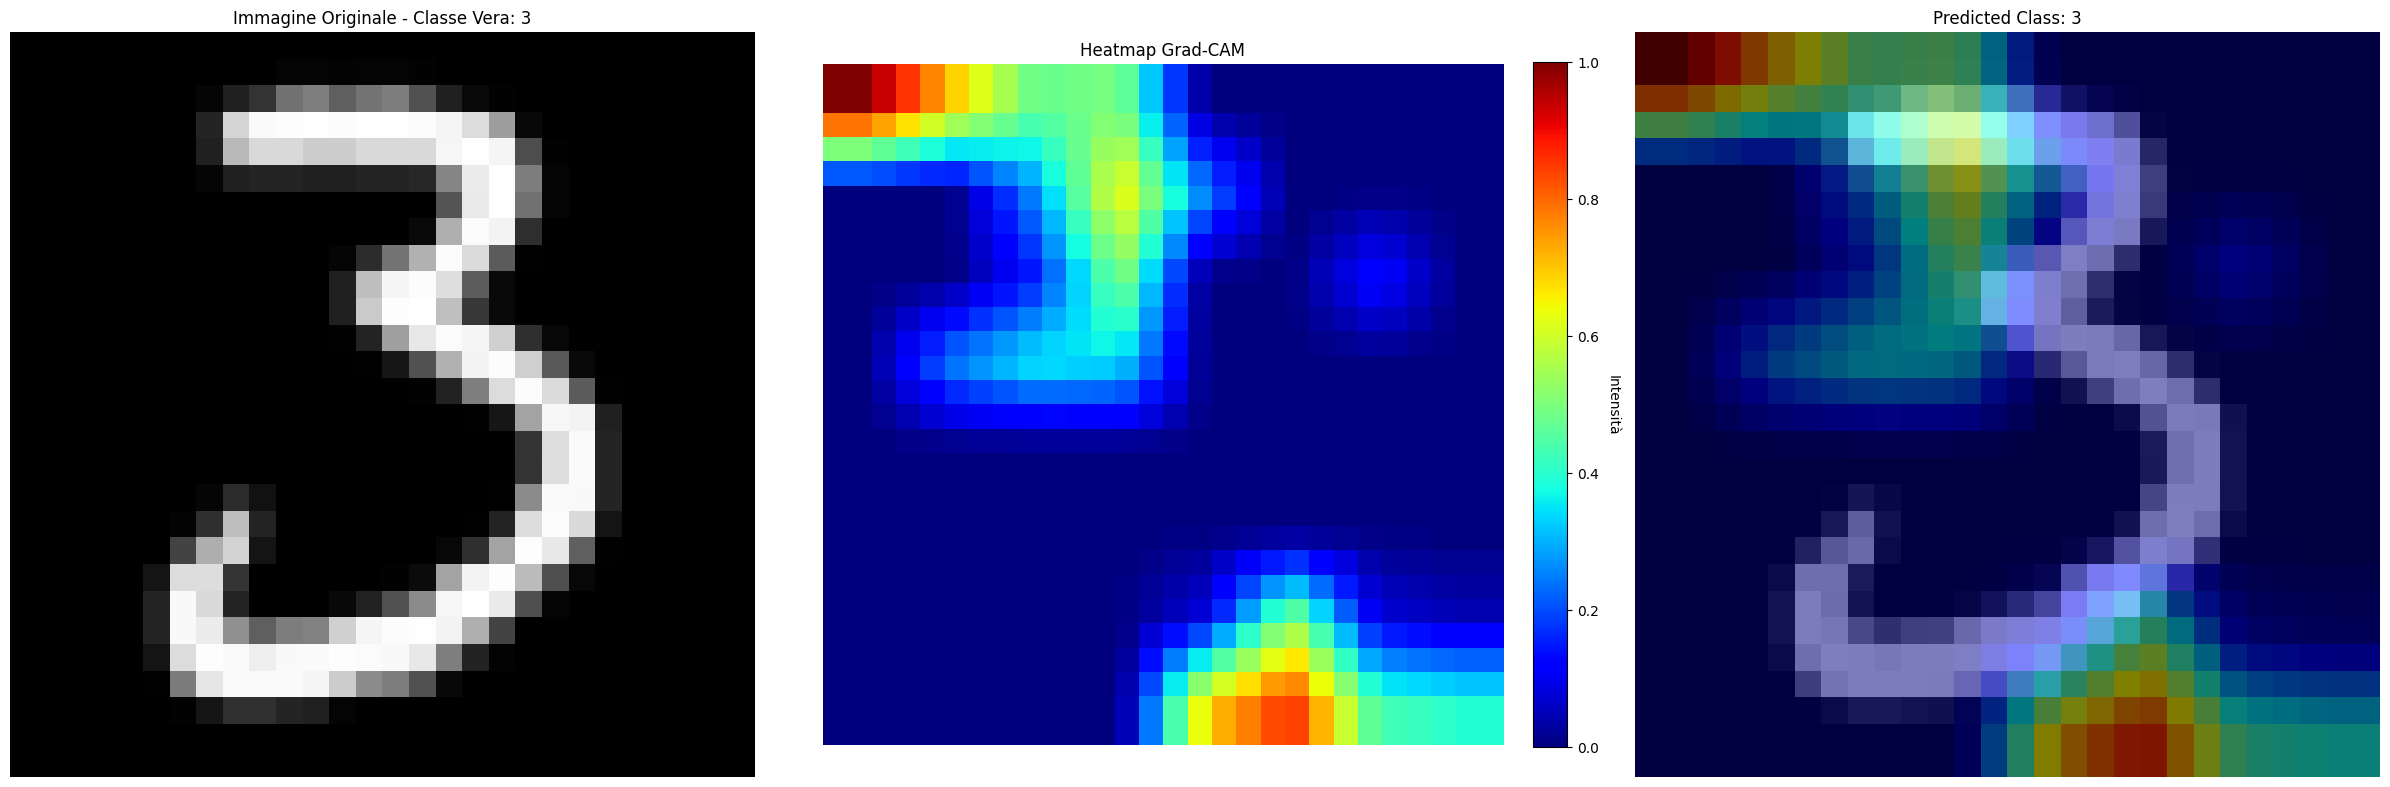

Plots salvati in: results/results_L2_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_15.png

Generando Grad-CAM per l'indice: 23


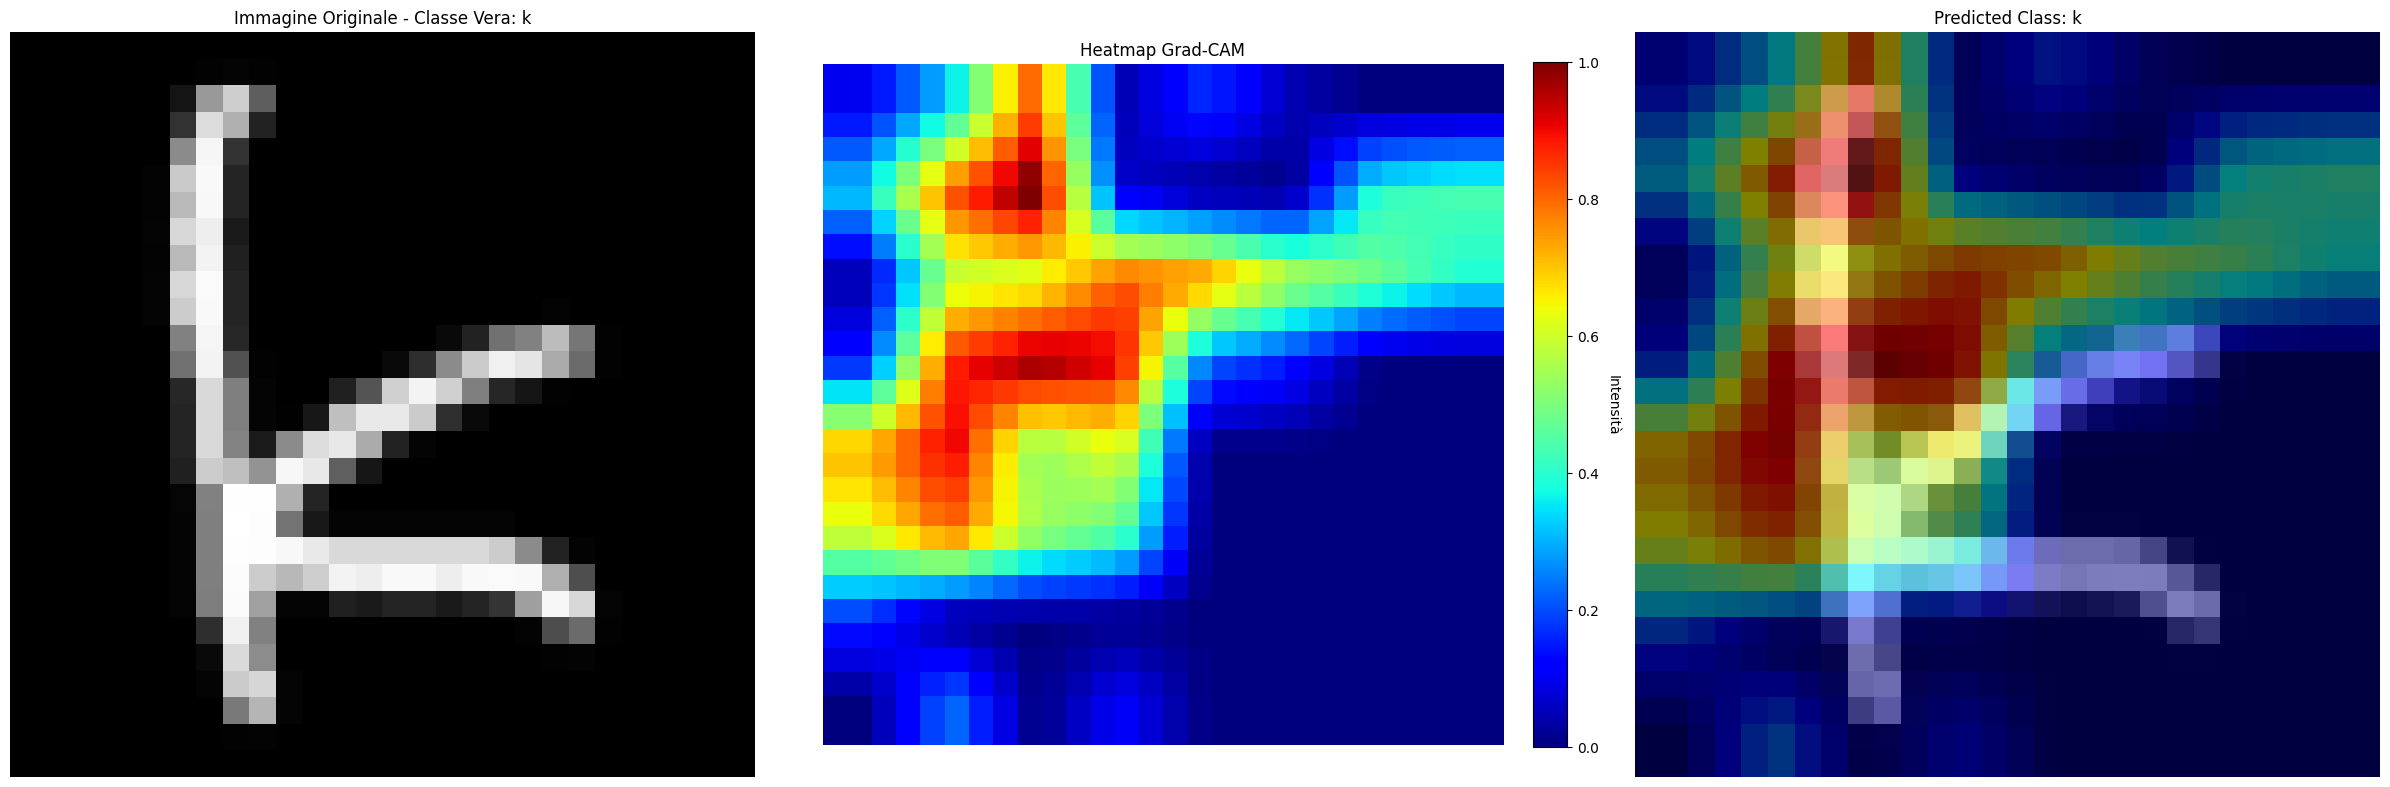

Plots salvati in: results/results_L2_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_23.png

Generando Grad-CAM per l'indice: 24


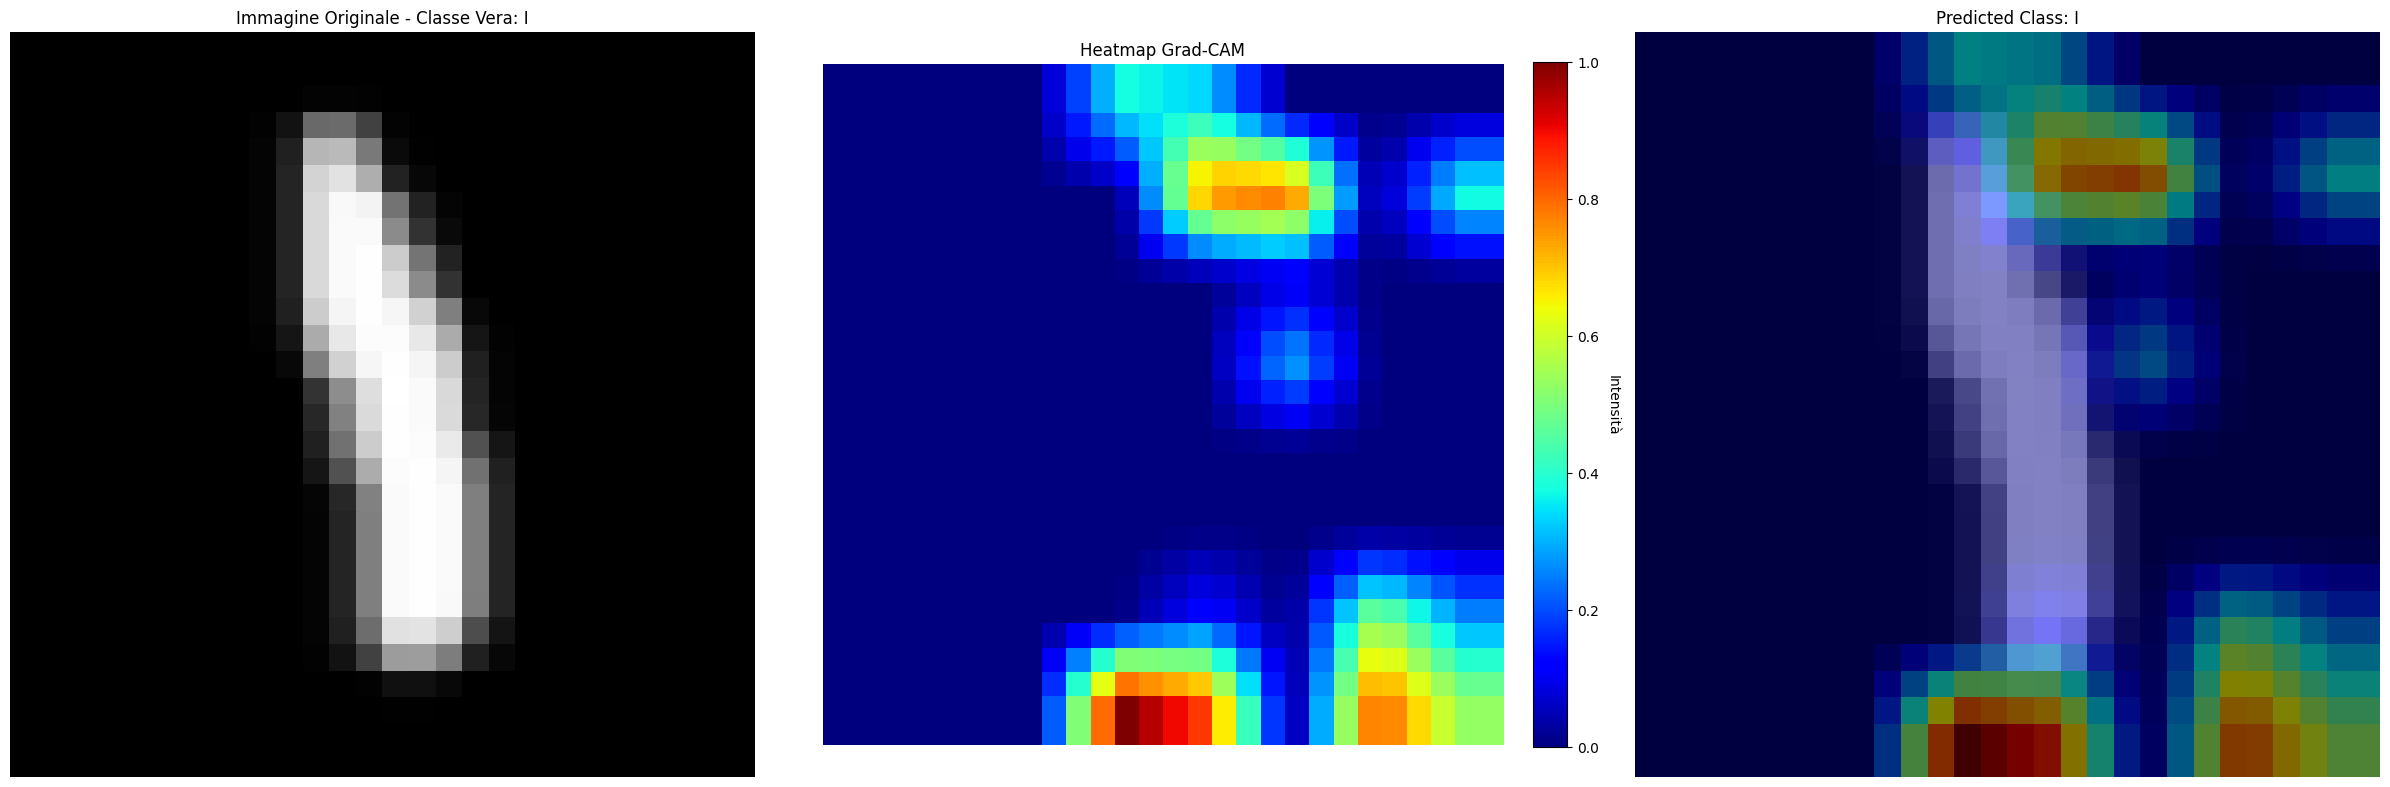

Plots salvati in: results/results_L2_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_24.png

Generando Grad-CAM per l'indice: 25


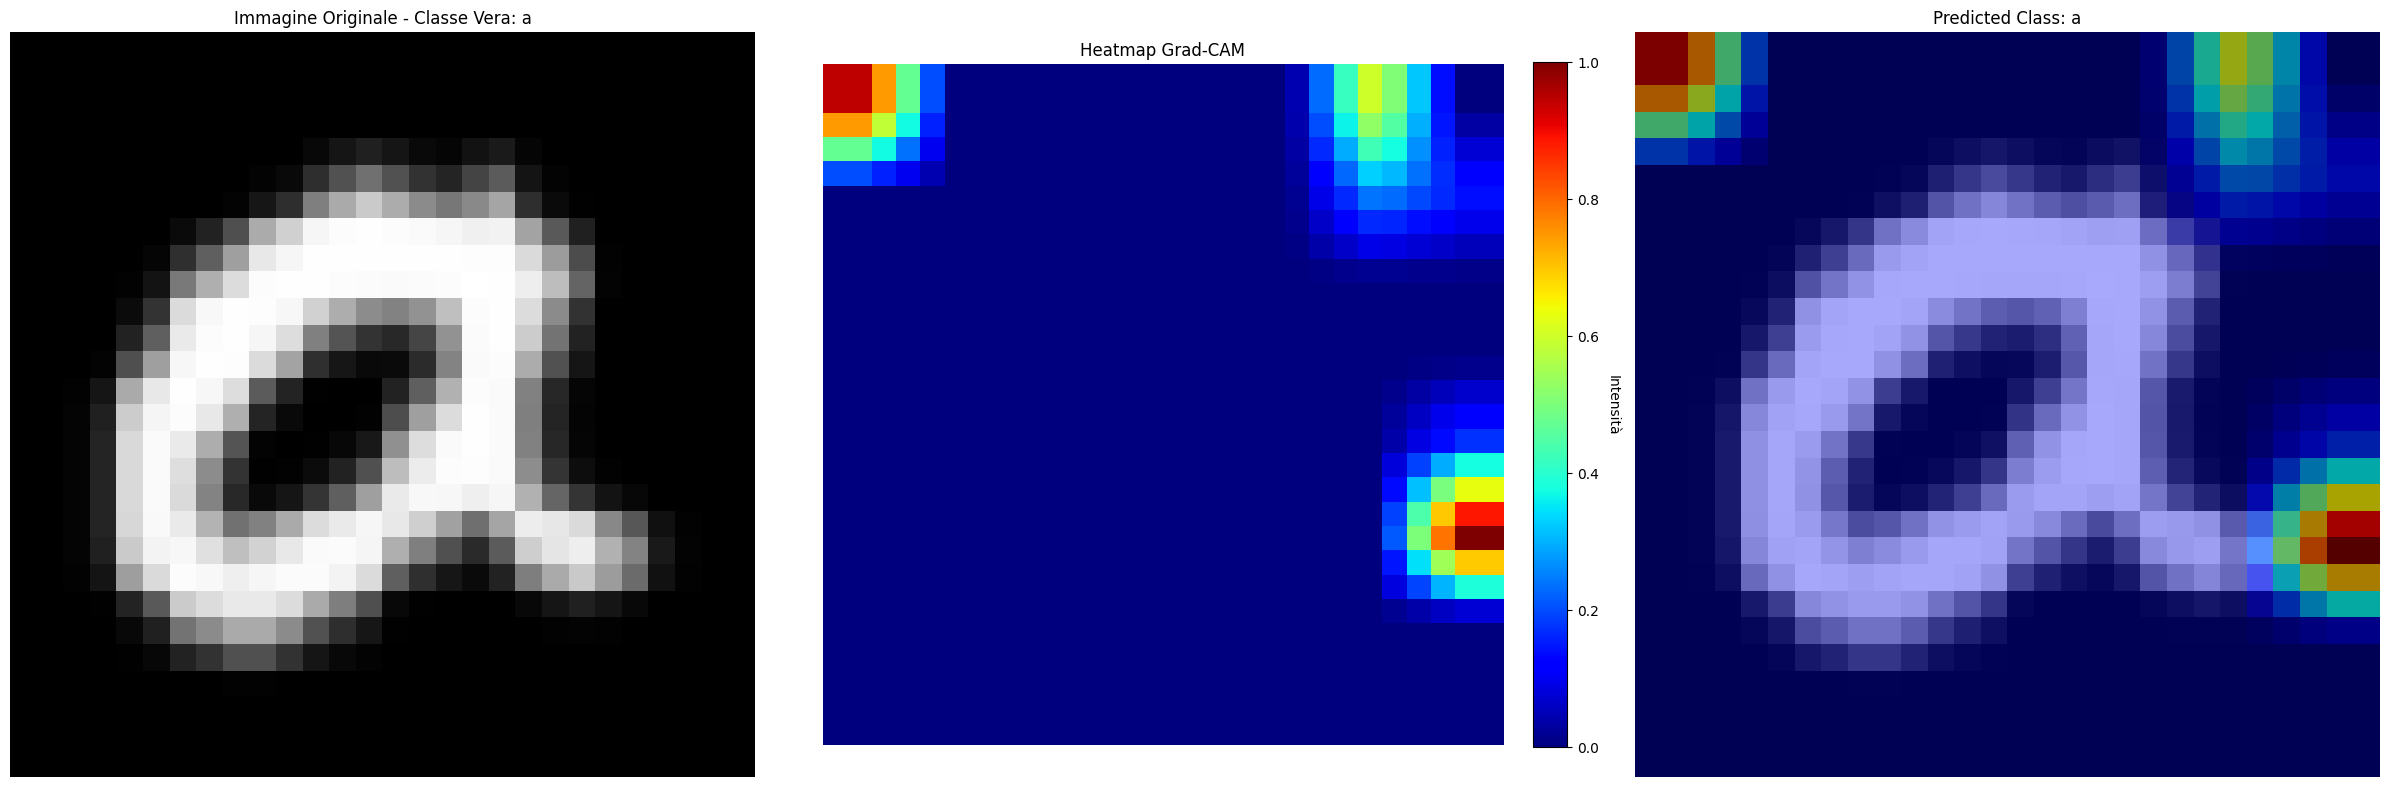

Plots salvati in: results/results_L2_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_25.png

Generando Grad-CAM per l'indice: 26


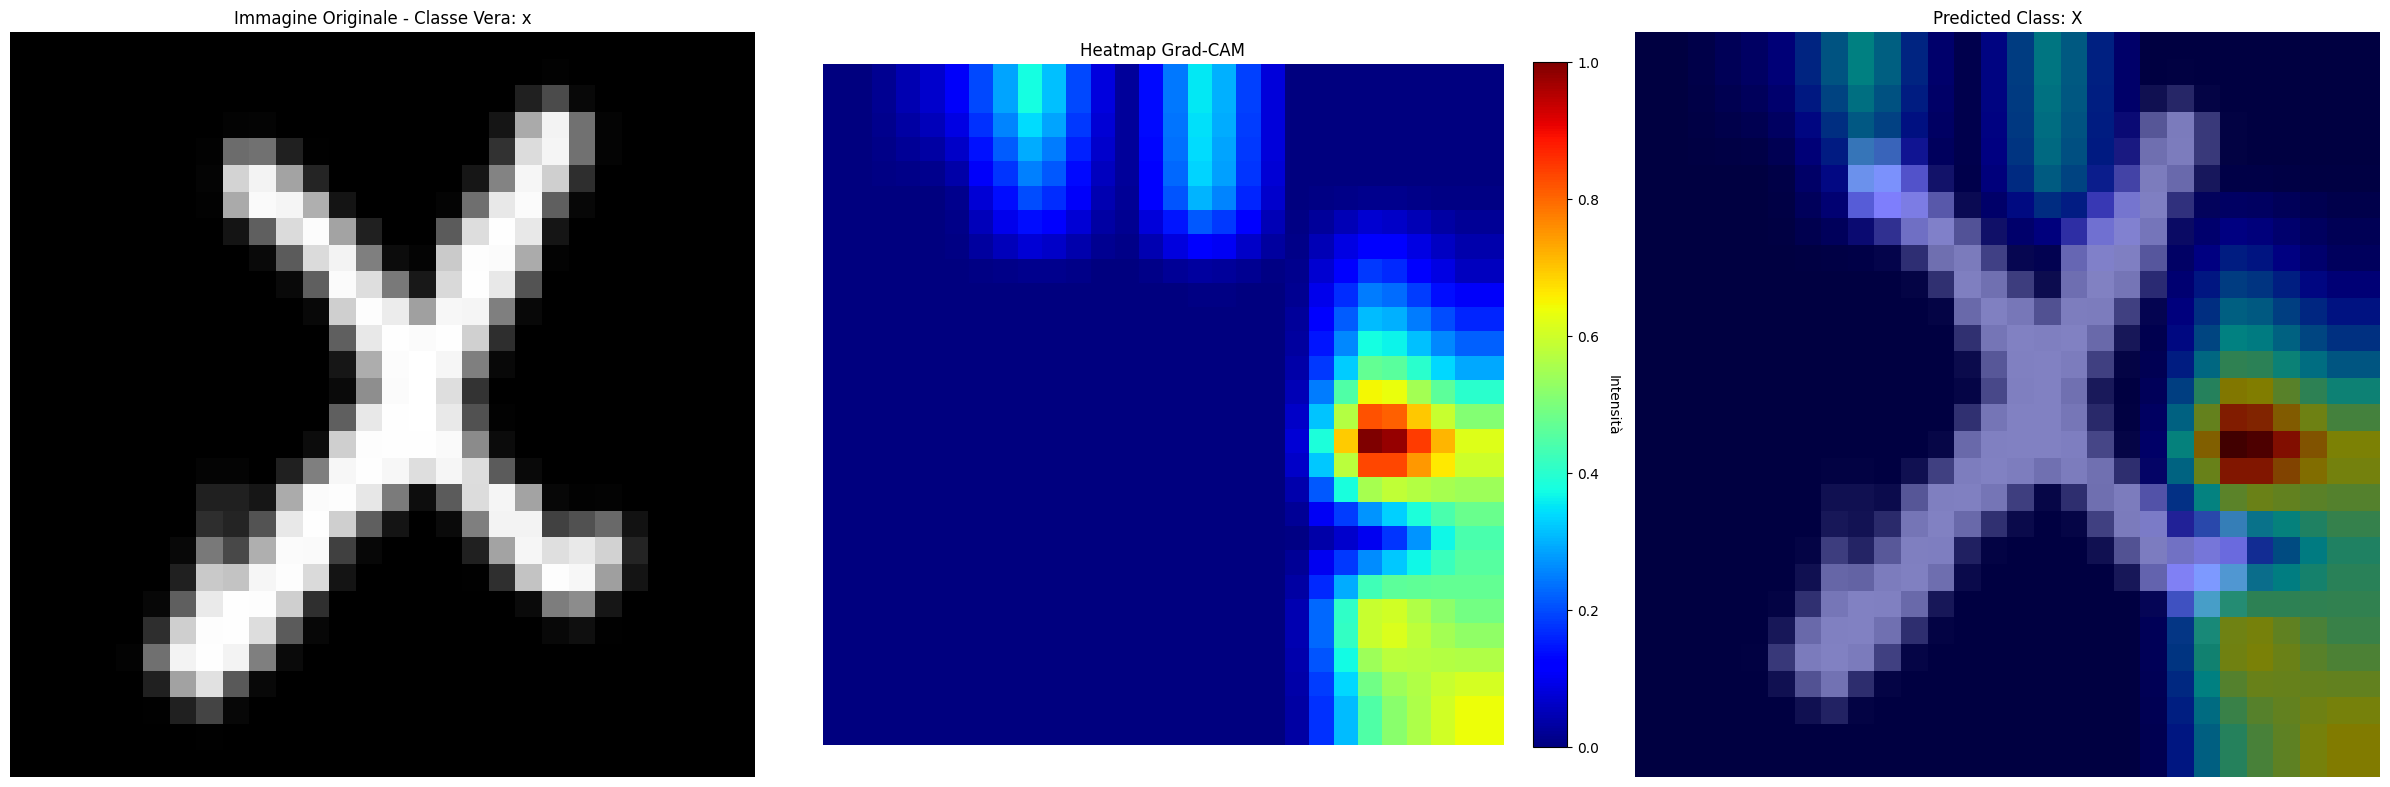

Plots salvati in: results/results_L2_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_26.png

Generando Grad-CAM per l'indice: 27


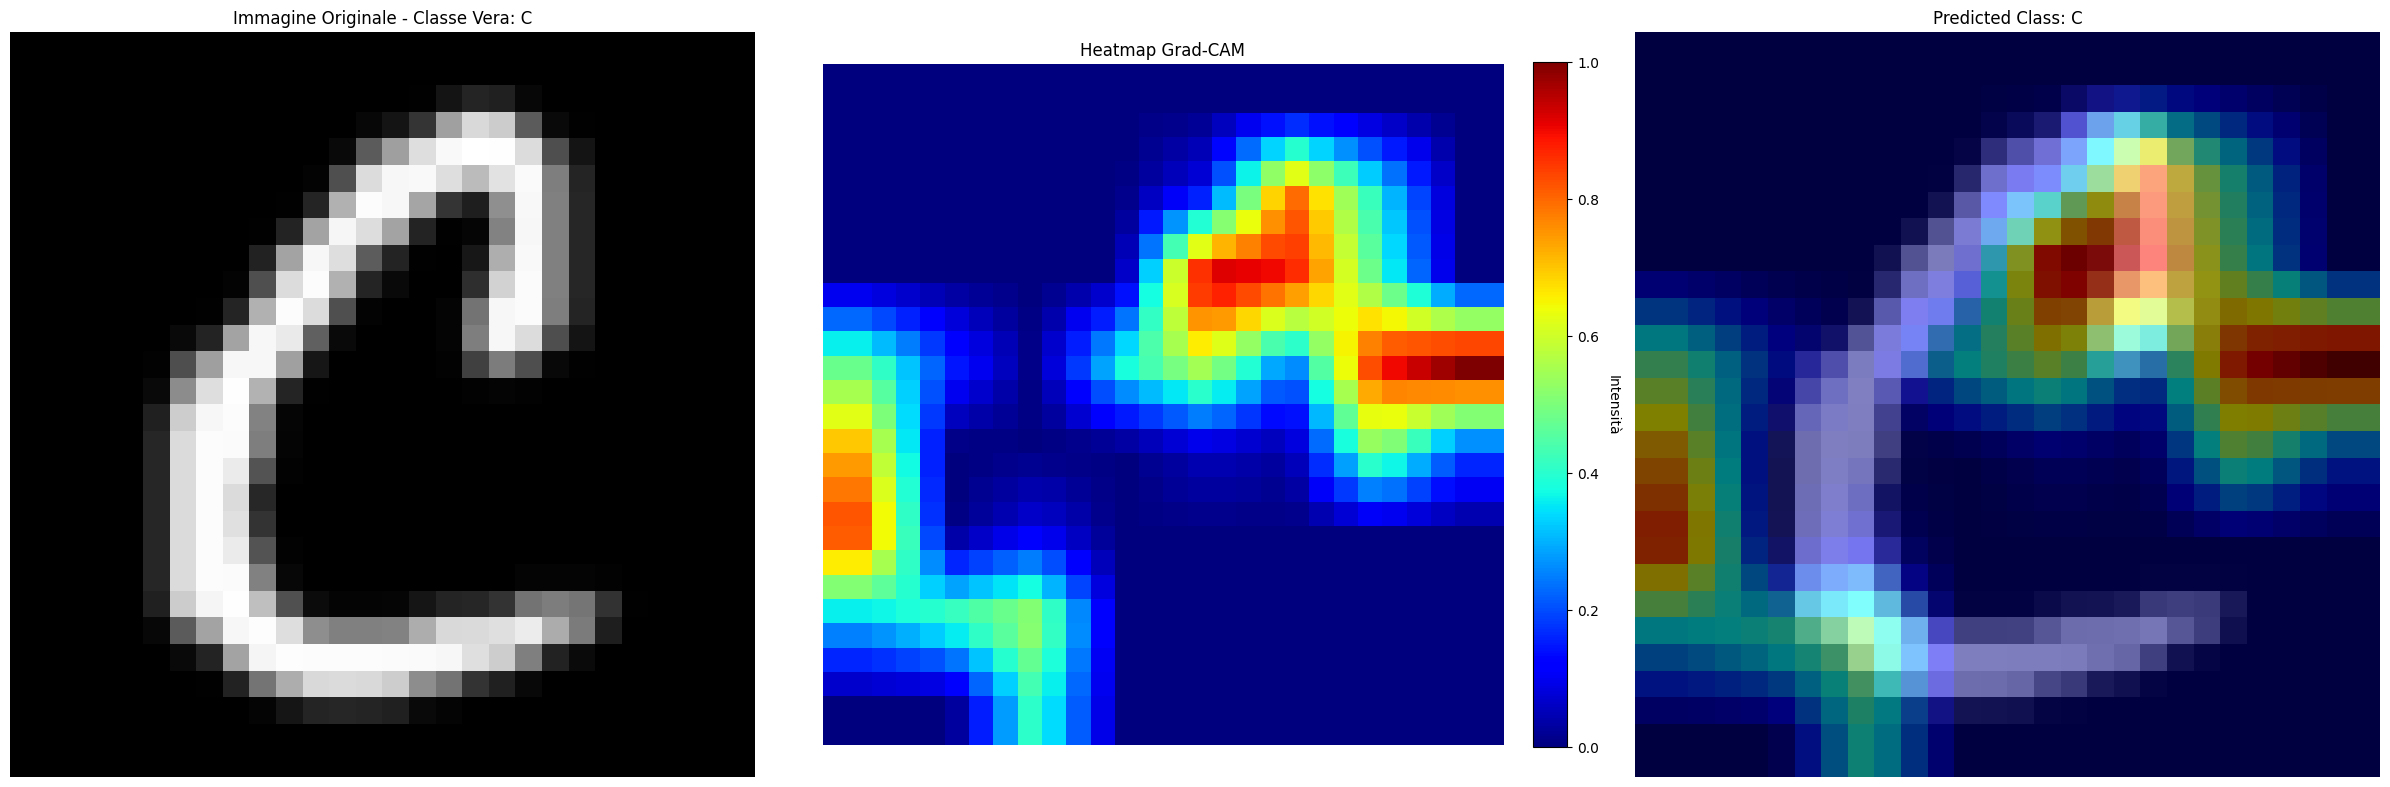

Plots salvati in: results/results_L2_SGD_lr0.01_5_3/KaNet5/gradcam_plots_sample_27.png


In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import struct
import random

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# -------------------------
# Definizione del Modello KAN
# -------------------------

from kan_convolutional.KANLinear import KANLinear
import kan_convolutional.convolution
from kan_convolutional.KANConv import KAN_Convolutional_Layer

class LeNet5_KAN(nn.Module):
    def __init__(self, num_classes=62):  # EMNIST Balanced ha 62 classi
        super(LeNet5_KAN, self).__init__()
        
        # Primo strato conv: input=1 canale, output=6 filtri, kernel=5x5
        self.conv1 = KAN_Convolutional_Layer(
            in_channels=1,
            out_channels=6,
            kernel_size=(5,5),
            stride=(1,1),
            padding=(0,0),
            dilation=(1,1),
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.ReLU,
            grid_eps=0.02,
            grid_range=(-1, 1)
        )
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Secondo strato conv: input=6 canali, output=16 filtri, kernel=5x5
        self.conv2 = KAN_Convolutional_Layer(
            in_channels=6,
            out_channels=16,
            kernel_size=(5,5),
            stride=(1,1),
            padding=(0,0),
            dilation=(1,1),
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.ReLU,
            grid_eps=0.02,
            grid_range=(-1, 1)
        )
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Dopo conv1+pool1 (28x28 -> conv5x5->24x24 -> pool->12x12)
        # Dopo conv2+pool2 (12x12 -> conv5x5->8x8 -> pool->4x4)
        # 16 canali da 4x4 => 16*4*4=256
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  

    def forward(self, x):
        # Passo 1: conv + pooling
        x = self.conv1(x)
        x = self.pool1(x)
        
        # Passo 2: conv + pooling
        x = self.conv2(x)
        x = self.pool2(x)
        
        # Flatten
        x = x.contiguous().view(x.size(0), -1)

        # Fully Connected Layers con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output Layer (senza attivazione)
        x = self.fc3(x)
        return x


# -------------------------
# Definizione del Dataset in Memoria
# -------------------------

class EMNISTMemoryDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor
        self.labels = labels_tensor

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# -------------------------
# Funzioni per leggere i file IDX
# -------------------------

def read_idx_images(file_path):
    """Legge immagini in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(file_path):
    """Legge etichette in formato IDX."""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# -------------------------
# Funzione di Denormalizzazione
# -------------------------

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# -------------------------
# Mappatura delle Classi
# -------------------------

def get_emnist_class_mapping():
    characters = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    return {i: char for i, char in enumerate(characters)}

# -------------------------
# Funzione per Estrarre un Campione Specifico
# -------------------------

def get_sample_by_index(dataset, index):
    if index < 0 or index >= len(dataset):
        raise IndexError("Indice fuori dal range del dataset.")
    sample_data, sample_target = dataset[index]
    return sample_data.unsqueeze(0), sample_target  # Aggiungi dimensione batch

# -------------------------
# Funzione per Generare e Visualizzare Grad-CAM
# -------------------------

def generate_gradcam_plots(sample_index):
    if sample_index < 0 or sample_index >= len(test_dataset):
        raise IndexError(f"Indice {sample_index} fuori dal range del dataset.")

    sample_data, sample_target = get_sample_by_index(test_dataset, sample_index)
    sample_data = sample_data.to(device)
    sample_target = sample_target.item()

    # Definisci il target layer della KAN convoluzionale (ad esempio conv2)
    target_layer = model.conv2

    # Inizializza GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Genera la heatmap Grad-CAM
    grayscale_cam = cam(input_tensor=sample_data, targets=None)
    grayscale_cam = grayscale_cam[0]

    grayscale_cam_normalized = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    with torch.no_grad():
        output = model(sample_data)
    pred_class = output.argmax(dim=1).item()

    original_image = denormalize(sample_data.cpu().clone(), [mean], [std]).squeeze().numpy()

    # Flip orizzontale e rotazione di 90 gradi anti-clockwise
    original_image = np.fliplr(original_image)
    original_image = np.rot90(original_image, k=1)

    grayscale_cam_normalized = np.fliplr(grayscale_cam_normalized)
    grayscale_cam_normalized = np.rot90(grayscale_cam_normalized, k=1)

    # Converti l'immagine originale in RGB e normalizzala tra 0 e 1
    original_image_rgb = np.stack([original_image]*3, axis=2)
    original_image_rgb = original_image_rgb / 255.0

    visualization = show_cam_on_image(original_image_rgb, grayscale_cam_normalized, use_rgb=True)

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title(f"Immagine Originale - Classe Vera: {class_mapping[sample_target]}")
    axs[0].axis('off')

    im = axs[1].imshow(grayscale_cam_normalized, cmap='jet')
    axs[1].set_title("Heatmap Grad-CAM")
    axs[1].axis('off')
    cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Intensità', rotation=270, labelpad=15)

    axs[2].imshow(visualization)
    axs[2].set_title(f"Predicted Class: {class_mapping[pred_class]}")
    axs[2].axis('off')

    plt.tight_layout()
    save_path = os.path.join(base_dir, f'gradcam_plots_sample_{sample_index}.png')
    plt.savefig(save_path)
    plt.show()

    print(f"Plots salvati in: {save_path}")

    cam = None  # Libera risorse

# -------------------------
# Funzione Principale
# -------------------------

def main():
    global model, test_dataset, class_mapping, mean, std, base_dir, device

    # Impostazioni
    learning_rate = 0.01
    optimizer_type = "SGD"
    grid_size = 5
    spline_order = 3
    norm_type = "L2"
    num_of_classes = 62
    batch_size = 1

    seed = 12
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')

    mean, std = 0.1307, 0.3081

    data_dir = '/home/magliolo/.cache/emnist/gzip/'

    base_dir = os.path.join(
        'results',
        f"results_{norm_type}_{optimizer_type}_lr{learning_rate}_{grid_size}_{spline_order}",
        'KaNet5'
    )
    model_dir = os.path.join(base_dir, "model")

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Directory del modello non trovata: {model_dir}")

    # Utilizzo del modello KAN invece del classico LeNet5
    model = LeNet5_KAN(num_classes=num_of_classes).to(device)

    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    if not checkpoints:
        raise FileNotFoundError(f"Nessun checkpoint trovato nella directory: {model_dir}")
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(model_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint caricato: {checkpoint_path}, Epoch: {checkpoint['epoch']}")
    model.eval()

    # Leggi i dati di test
    test_images_path = os.path.join(data_dir, 'emnist-byclass-test-images-idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 'emnist-byclass-test-labels-idx1-ubyte')

    print("Leggendo i dati di test...")
    images_test = read_idx_images(test_images_path)
    labels_test = read_idx_labels(test_labels_path)

    test_images_tensor = torch.from_numpy(images_test.copy()).unsqueeze(1).float()
    test_labels_tensor = torch.from_numpy(labels_test.copy()).long()

    test_images_tensor = (test_images_tensor - mean) / std

    test_images_tensor = test_images_tensor.to(device)
    test_labels_tensor = test_labels_tensor.to(device)

    test_dataset = EMNISTMemoryDataset(test_images_tensor, test_labels_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Test size: {len(test_loader.dataset)}")
    print(f"Numero di classi uniche nel dataset di test: {len(set(labels_test))}")
    print(f"Etichette uniche nel dataset di test: {sorted(set(labels_test))}")

    class_mapping = get_emnist_class_mapping()

    # Indici di esempio
    sample_indices = [9, 15, 23, 24, 25, 26, 27]

    for sample_index in sample_indices:
        print(f"\nGenerando Grad-CAM per l'indice: {sample_index}")
        try:
            generate_gradcam_plots(sample_index)
        except Exception as e:
            print(f"Errore nella generazione della heatmap per l'indice {sample_index}: {e}")

if __name__ == "__main__":
    main()
